2017 Edition

The work presented in this notebook has been done jointly by [Simone Rossi](https://srossi93.github.io/) and [Matteo Romiti](https://github.com/MatteoRomiti)

Advances in imaging equipment and automation have led to an overabundance of data on the functioning of the brain. Technologies today can sample brain activity from a large number of neurons in a large region while organisms are actively behaving. For example, by simultaneously recording the electrical activity of every neuron of the mouse brain over an extended period of time, the amount of data generated will create completely new paradigms for biology, that will require the development of tools to extract value from such unprecedented amount of information.

In this Notebook, we use PySpark and the [Thunder project](https://github.com/thunder-project/thunder), which is developed on top of PySpark, for processing large amounts of time series data in general, and neuroimaging data in particular. We will use these tools for the task of understanding some of the structure of Zebrafish brains, which is a typical (and simple) example used in Neuroimaging. Using Thunder, we will cluster different regions of the brain (representing groups of neurons) to discover patterns of activity as the zebrafish behaves over time.

**Note**: Please, use the documentation for the [Thunder API](http://docs.thunder-project.org/) to learn the details of function calls!


# Goals

The main goals of this notebook are:

1. Learn about Thunder and how to use it
2. Revisit the K-Means algorithm and the method for choosing K
3. Learn alternative approaches to improve the results


# Steps
1. In section 1, we go through some background concepts that are used in this notebook.
2. Next, in section 2, we will get familiar with Thunder, its methods and its data types, by working on some simple tasks.
3. Finally, in section 3, we will build a model to cluster the neurons of a zebrafish based on their behavior. In this step, we will learn about how to use K-Means when the value of K is unknown. Finally, some tricks to improve the results are introduced.

# 1. Background concepts

In this section, we cover the terminology and the concepts that constitute the domain knowledge for this notebook.

As it should be well-known, a `pixel` is a combination of "**pic**ture **el**ement": digital images can be modeled as simple 2-dimensional (2D) matrices of intensity values, and each element in the matrix is a pixel. In color images, a pixel contains values of red, green, and blue channels. In a grayscale image, the three channels have the same value, such that each pixel is reduced to be a single value.

A single 2D image is not nearly enough to express 3D objects, which use a **voxel**, representing a value of the 3D image on a regular grid in a three-dimensional space.  A possible technique to work on 3D images is to acquire multiple 2D images of different slices (or `planes`, or `layers`) of a 3D object, and stack them one on top of each other (a z-stack). This ultimately produces a 3D matrix of intensity values, where each value represents a `volume element` or `voxel`.

![](https://upload.wikimedia.org/wikipedia/commons/b/b4/Voxelgitter.png)
<div style="text-align:center;">This z-stack image has 4 layers. A point is a voxel. It can be determined by the layer's index and the position in that layer.</div>

In the context of the Thunder package, we use term `image` for `3D-image` or `stack image`. Thunder uses `Image` type to  represent 3D-image. Each `Image` object is a collection of either 2D images or 3D volumes. In practice, it wraps an n-dimensional array, and supports either distributed operations via Spark or local operations via  numpy, with an identical API.

Stack-images can represent 3D objects, but it can be difficult to take the temporal relationship of the images into account. To do that, we need another data structure that shows the changes of voxels over time. In the Thunder package, the internal `Series` type can be used exactly for this purpose. Each `Series` is a 1D array such that each element is a value of the voxel at a timestamp.

The most common series data is time series data, in which case the index is time and each record is a different signal, like a channel or pixel.

We now have sufficient material to start playing with Thunder !!!

# 2. Let's play

Well, wait a second before we play... Remember, we're going to use Spark to perform some of the computations related to this Notebook. Now, when you spin a Zoe Notebook application (this comment is valid for students at Eurecom), you'll gain access to an individual, small Spark cluster that is dedicated to your Notebook. This cluster has two worker machines, each with 6 cores. As such, a good idea to obtain smooth performance and a balanced load on the workers, is to ```repartition``` your data (i.e., the RDDs you use to represent images or time series).

In this Notebook we **expect** students to take care of repartitioning, and such care will be compensated by bonus points.

## 2.1. Play with Image objects

### a. Loading image data

Both `images` and `series` can be loaded from a variety of data types and locations. You need to specify whether data should be loaded in 'local' mode, which is backed by a numpy array, or in 'spark' mode, which is backed by an RDD by using the optional argument `engine`. The argument `engine` can be either `None` for local use or a SparkContext for` distributed use with Spark.

```python
import thunder as td

# load data from tif images
data = td.images.fromtif('/path/to/tifs')

# load data from numpy-arrays
data = td.series.fromarray(somearray)
data_distributed = ts.series.fromarray(somearray, engine=sc)
```

We can load some example image data by:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import thunder as td
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
# import two function to draw images easier
from showit import image as draw_image
from showit import tile as draw_tile

In [45]:
# load some example image data
image_data = td.images.fromexample('fish', engine=sc)

# print the number of images
print(image_data.count())

20


<div class="alert alert-success">
We think it's appropriate to provide an <b>introduction to Neuroimaging</b> and to the dataset we're dealing with, so as to understand a bit more.
<br><br>
<b>Neuroimaging</b> is a term that includes a variety of methods and technologies. These techniques are oftentimes referred to as "brain scans". Others use the more scientific term <b>in vivo imaging</b>, meaning that biological experiments are carried out on living organisms – either on people or animals.
<br><br>
In-vivo technology breaks down into two main types:
<ul>
<li>Structural Imaging</li>
<li>Functional Imaging</li>
</ul>
<br>
<b>Structural imaging</b> provides images of the brain’s anatomical structure. This type of imaging helps in the <b>diagnosis of brain injury</b>, and the diagnosis of certain diseases. The two types of structural imaging techniques are <b>computerized axial tomography</b> (CAT), and <b>magnetic resonance imaging</b> (MRI).
<br><br>
<b>Functional imaging</b> provides images of the brain as patients complete tasks, such as solving math problems, reading, or responding to stimuli such as auditory sounds or flashing lights. The area or areas of the brain that are involved with completing or responding to these tasks "light up", giving researchers a visual 3-D view of the parts of the brain involved with each type of task.
Three main types of functional imaging technologies are: <b>positron emission tomography</b> (PET); <b>regional cerebral blood flow</b> (rCBF); and <b>functional magnetic resonance imaging</b> (fMRI).
<br><br>
For many researchers, especially cognitive neuropsychologists and those in the neurosciences, <b>fMRI</b> has become the <b>most popular imaging technology</b>.

fMRI uses the same machine as structural MRIs, permitting researchers to complete both functional and structural neuroimaging at the same time. Using <b>more powerful magnets</b>, however, fMRI gives detailed neural activity in the brain and spinal cord unlike a regular MRI.

fMRI works on the magnetic properties of the brain’s cells called neurons. As with all cells, neurons require energy to function. In neurons, glucose and oxygen provide this energy, which is delivered by the bloodstream.

<b>Neuronal firing</b> affects the <b>oxygenation and deoxygenation</b> of blood, giving an indirect measure of <b>neuronal activity</b>. In this way, researchers can view neural activity taking place in the brain as patients complete tasks, and are able to<b> construct "maps"</b> of neural network systems.
<br><br>

The technique that [1] used to retrieve the images we will work with is called <b>Light-sheet Functional Imaging</b>, where light-sheet microscopy is used to record the activity of almost all neurons in the brain simultaneously at single-cell resolution.
</div>




In [46]:
image_data.repartition(12)

Images
mode: spark
dtype: uint8
shape: (20, 2, 76, 87)

<div class="alert alert-success">  
Even if we are only dealing with 20 images, probably in 3D, we plan to do heavy operations on them. It's better to use all our cores.
</div>

### b. Inspecting image data

Shape of the data: (20, 2, 76, 87)
Shape of the data of the first image: (2, 76, 87)
Data of the first image:
[[[26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 27 27 26]
  ..., 
  [26 26 26 ..., 27 27 26]
  [26 26 26 ..., 27 26 26]
  [25 25 25 ..., 26 26 26]]

 [[25 25 25 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  ..., 
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]]]


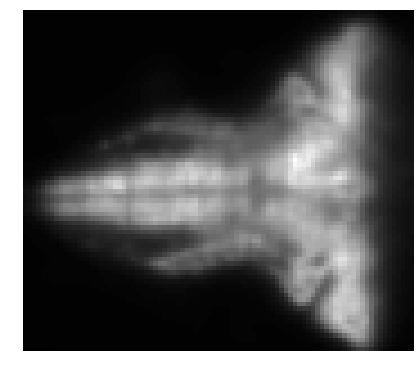

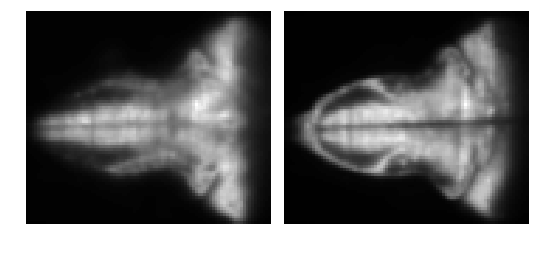

In [47]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# # import two function to draw images easier
# from showit import image as draw_image
# from showit import tile as draw_tile

print("Shape of the data:", image_data.shape)

first_image = image_data.first() # get the values of Image object
# or first_image = image_data[0] # get the Image object

print("Shape of the data of the first image:", first_image.shape)

print("Data of the first image:")
print(first_image)

# draw the first layer of the first image
draw_image(first_image[0])

# draw all layers of the first image
draw_tile(first_image)

# we can use index slices to take images
samples = image_data[0:6]



From the result above, the shape of the loaded data is (20, 2, 76, 87). It means we have total 20  3D images objects. Each image has 2 layers, each layer has size 76x87. 

Note that, although  data  is not itself an array (it can be a kind of RDD), we can index into it using bracket notation, and pass it as input to plotting methods that expect arrays. In these cases, the data will be automatically converted.

One of the advantages of working in Python is that we can easily visualize our data stored into Spark RDDs using the Matplotlib library. Function `draw_image` and `draw_tile` that take advantages of Matplotlib are examples.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 1

<div class="alert alert-info">  
a) Use the function `imshow` from matplotlib to plot each layer of the first image in `image_data`.  

b) Discuss the choice of parameters you use for the method `imshow`  

</div>

```python

img = image_data.first() 
# or:
# img = image_data[1]

# show the first layer
plt.imshow(img[...], interpolation='nearest', aspect='equal', cmap='gray')
plt.title("Layer 0 of the first image")
plt.show()

# show the second layer
...
```

<div class="alert alert-success">  
We first wanted to see the grayscale version and the colored version of the layers one next to the other. 
We then tried all the the possible values of `interpolation`, and we selected the ones that show differences. The baseline is given by `none`, while a common interpolation is `neareast`, the `bicubic` yields an obfuscated picture, while `spline36` and `gaussian` are able to render the image without showing a pixelated image. We leave the aspect ratio as the one of the original image so as not to modify possible patterns.
</div>

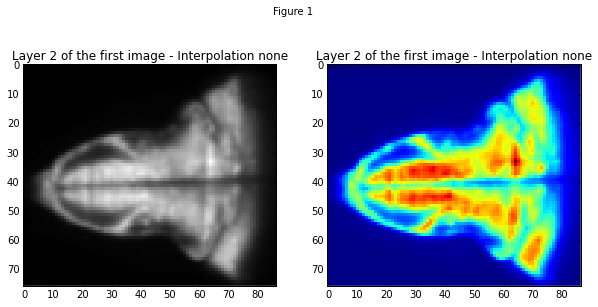

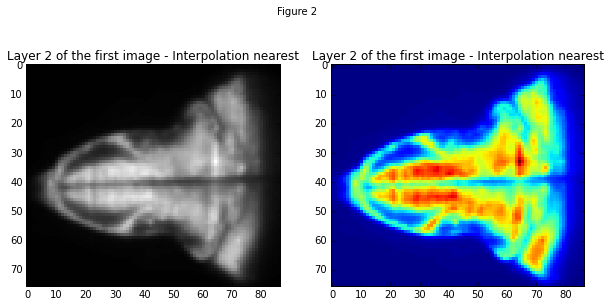

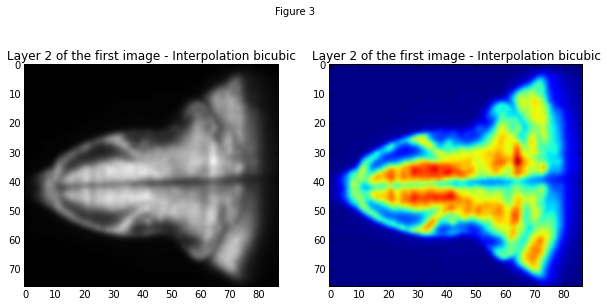

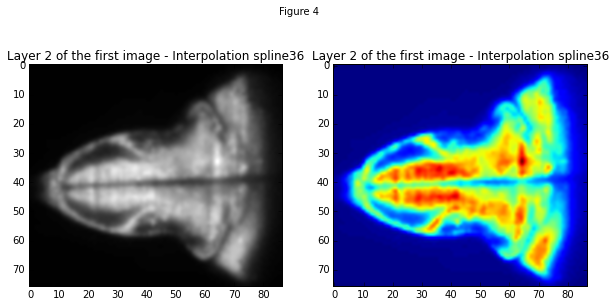

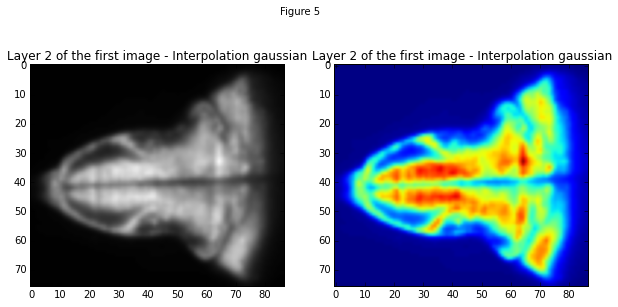

In [48]:
img = image_data.first() 

layer = 1
# for i in ['none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', \
#           'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', \
#           'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']:
for i,n  in zip(['none', 'nearest', 'bicubic', 'spline36', 'gaussian'], range(5)):
    plt.figure(figsize=(10,5))
    plt.suptitle("Figure %d" %(n+1))
    plt.subplot(121)
    plt.imshow(img[layer], interpolation=i, aspect='equal', cmap='gray')
    plt.title("Layer %d of the first image - Interpolation %s" % (layer+1, i))
    plt.subplot(122)
    plt.imshow(img[layer], interpolation=i, aspect='equal')
    plt.title("Layer %d of the first image - Interpolation %s" % (layer+1, i))
    plt.show()


<div class="alert alert-success">  
As explained in the introduction, with the colored images we are able to observe the neuronal activity. Red pixels represent active regions of the brain, while pixels with a blue color belong to inactive areas.
<br><br>
This dataset contains images of the zebrafish brain, but we noticed they're limited to the hindbrain section as reported in Figure 4b in [2], where we have wider homogeneous areas. In the midbrain and in the forebrain instead we have small and heterogeneous regions. 

</div>

Then, we can perform operations that aggregate information across images.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Calculate the standard deviation across all images you have in `image_data` (that is, our dataset). To clarify, let's focus on an individual layer (say the first layer of each image). For every `voxel`, compute the standard deviation of its values across different images for the same layer. Visualize the standard deviation you obtain, for example concerning a single layer (as before, say the first layer).

</div>

<div class="label label-success">HINT 1</div> to avoid wasting time and energy, make sure you lookup for methods that could help answer the question from the Thunder documentation.  

<div class="label label-success">HINT 2</div> We can also use function `draw_image(<data>)` to plot an image in a simple way instead of using many statements with matplotlib as before.

<div class="label label-danger">NOTE</div> Comment the image you obtain. What does it mean to display the standard deviation across all images in a single layer?

```python
####!@SOLUTION@!####
# calculate standard deviation of images
std_imgs = image_data....
draw_image(...)
```

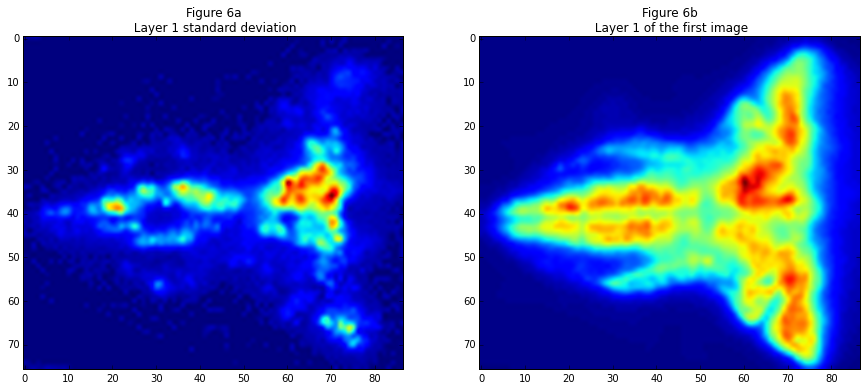

In [49]:
std_imgs = image_data.std()

layer = 0

interp = 'spline36'

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(std_imgs.first()[layer], interpolation=interp, aspect='equal')
plt.title("Figure 6a \n Layer %d standard deviation" % (layer+1))
plt.subplot(122)
plt.imshow(image_data.first()[layer], interpolation=interp, aspect='equal')
plt.title("Figure 6b \n Layer %d of the first image " % (layer+1))

plt.show()

<div class="alert alert-success">  
On the left we have the standard deviation in layer 1: hot regions represent cerebral matter that changes its neuronal activity the most. On the right we show the first image of the first layer as a comparison.
<br><br>
During this time frame, we might also conclude that the fish was presented a stimulus in left direction as the image below reports (arrows upwards) since we notice that the standard deviation values are higher in the yellow-green region which are associated to that direction.  
</div>

<p style="text-align: center;">Figure 6c</p>
![alt text](http://i.dailymail.co.uk/i/pix/2014/07/30/1406718005810_wps_6_Fish_brain_neurons_png.jpg)

<div class="alert alert-success">

Direction tuning maps of whole-brain neural activity measured in a larval zebrafish with light-sheet microscopy while zebrafish were presented visual stimuli. Every pixel is colored on the basis of its preference for a particular direction of motion, i.e., the motion it responded the most to. <a href="http://www.dailymail.co.uk/sciencetech/article-2710612/WATCH-Electrical-storm-thoughts-deep-zebrafishs-brain-80-000-neurons-fire-off.html">Source</a>
<br><br>
This image is a 2-dimensional projection of a 3D representation of the brain. The reader can visualize the full 3D image <a href="https://www.youtube.com/watch?v=Gg_5fWllfgA&t=489s">here</a>.
</div>

### c. Selecting samples of image data

The Images API offers useful methods for working with large image data. For example, in some cases it is necessary to subsample each image, to make sure we can analyze it efficiently.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3

<div class="alert alert-info">  
The source code below subsamples image data with different ratios on different dimensions.   

a) Complete the source code to plot the first layer of the first image.   

b) What is the shape of `image_data` before and after subsampling?  

</div>

```python
subsampled = image_data.subsample((1, 5, 5))
# Stride to use in subsampling. If a single int is passed, each dimension of the image
# will be downsampled by this same factor. If a tuple is passed, it must have the same
# dimensionality of the image. The strides given in a passed tuple will be applied to
# each image dimension
plt.imshow(..., interpolation=..., aspect=..., cmap=...) 
plt.title("Subsampling image")
plt.show()
print("Before subsampling:", ...)
print("After subsampling:", ...)
```

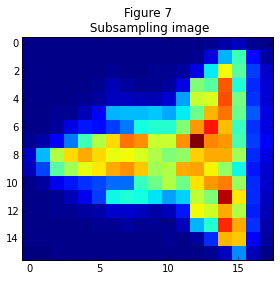

Before subsampling: (20, 2, 76, 87)
After subsampling: (20, 2, 16, 18)


In [50]:
subsampled = image_data.subsample((1, 5, 5))
# Stride to use in subsampling. If a single int is passed, each dimension of the image
# will be downsampled by this same factor. If a tuple is passed, it must have the same
# dimensionality of the image. The strides given in a passed tuple will be applied to
# each image dimension
plt.imshow(subsampled.first()[0], interpolation='nearest', aspect='equal') 
plt.title("Figure 7 \n Subsampling image")
plt.show()
print("Before subsampling:", image_data.shape)
print("After subsampling:", subsampled.shape)

<div class="alert alert-success">  
We downsampled horizontally and vertically by a stride of 5.
</div>

Note that `subsample` is an RDD operation, so it returns immediately. Indeed, we know that in Spark you must apply a RDD action to trigger the actual computation.

### d. Converting image data
We can also convert an RDD of images to a RDD of series by:

In [51]:
seriesRDD = image_data.toseries()
seriesRDD.cache()

Series
mode: spark
dtype: uint8
shape: (2, 76, 87, 20)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">
According to your understanding about `Series` objects which was introduced in section 1, what is the shape of `seriesRDD` and its elments ?  

Comment your results, don't just display numbers.
</div>

In [52]:
seriesRDD

Series
mode: spark
dtype: uint8
shape: (2, 76, 87, 20)

<div class="alert alert-success">  
We still have two layers of 76x87 images, each layer has 20 different images changing over time. Hence, a voxel is made of 20 different elements which differ along the time axis.
</div>

For a large data set that will be analyzed repeatedly as a `Series`, it will ultimately be faster and more convienient to save `Images` data to a collection of flat binary files on a distributed file system, which can in turn be read back in directly as a `Series`, rather than repeatedly converting the images to a `Series` object. This can be performed either through a ThunderContext method, `convertImagesToSeries`, or directly on an Images object, as done below:

In [53]:
# image_data.toseries().tobinary('directory', overwrite=True)
# ts = td.series.frombinary('directory', engine=sc)

We will study about `Series` object in the next section.

## 2.2. Play with Serises objects

### a. Loading Series data

In this section, we use a sample data to explore `Series` objects.

In [54]:
# series_data = td.series.fromexample('fish', engine=sc)
# series_data = td.series.frombinary(path='s3n://thunder-sample-data/series/fish', engine=sc)
series_data = image_data.toseries()
series_data.cache()

Series
mode: spark
dtype: uint8
shape: (2, 76, 87, 20)

<div class="alert alert-success">
We can cache `series_data` so as to have faster computations.
</div>

### b. Inspecting Series data

`Series_data` is a distributed collection of key-value records, each containing a coordinate identifier and the time series of a single `voxel`. We can look at the first record by using `first()`. It’s a key-value pair, where the key is a tuple of `int` (representing a spatial coordinate within the imaging volume) and the value is an one-dimensional array.

In [55]:
first_series = series_data.first() # get the values of Series object
#first_series = series_data[0] # get a Series object

print("Shape of series:", series_data.shape)
print("The first series:", first_series)
print("...which corresponds to...")
print("...all the values of first layer at (0,0) ", np.array(series_data[0,0,0]))
print("All the values of second layer at (0,0) ", np.array(series_data[1,0,0]))
print("Each element in series has", len(first_series), "values")

# print the 10th value of voxel (0,0,0)
# layer = 0
# coordinator = (0,0) in that layer
print("10th value of voxel (0,0,0):", np.array(series_data[0,0,0,10]))

Shape of series: (2, 76, 87, 20)
The first series: [26 26 26 26 26 26 26 25 26 25 25 25 26 26 26 26 26 26 26 26]
...which corresponds to...
...all the values of first layer at (0,0)  [26 26 26 26 26 26 26 25 26 25 25 25 26 26 26 26 26 26 26 26]
All the values of second layer at (0,0)  [25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]
Each element in series has 20 values
10th value of voxel (0,0,0): 25


The loaded series data is a multi-dimensional array. We can access the values of a voxel in time series by using a tuple as above. In our data, each voxel has 20 values corresponding to 20 states at 20 different times.

### c. Selecting Series data
Series objects have a 1D index, which can be used to subselect values.

In [56]:
print("shape of index:", series_data.index.shape)
# select all the values with index 0,..,7, then take the first series = voxel of first layer at (0,0) 
print("the first element of a subset", series_data.between(0,8).first())  

shape of index: (20,)
the first element of a subset [26 26 26 26 26 26 26 25]


Values can be selected based on their index:

In [57]:
print(series_data.select(lambda x: x > 3 and x < 8).index)
print(series_data.select(lambda x: x > 3 and x < 8).first())


[4, 5, 6, 7]
[26 26 26 25]


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 5
<div class="alert alert-info">

Plot the first 20 values of **all** series objects (that is the values of a voxel) in the series data. This means, on the same plot, you should visualize the values each voxel takes in the first 20 time intervals.

</div>

```python
import numpy as np

# only select the first 20 states of each object
samples = series_data.between(...).tordd().values().collect()

plt.plot(np.array(samples).T)
plt.show()

```

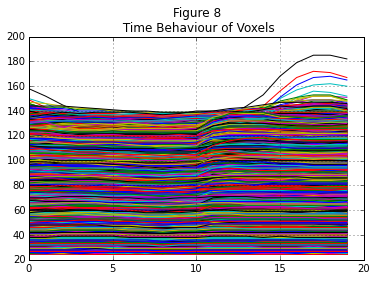

In [58]:
# only select the first 20 states of each object
samples = series_data.between(0, 20).tordd().values().collect()
plt.plot(np.array(samples).T)
plt.title("Figure 8 \n Time Behaviour of Voxels")
plt.grid()
plt.show()

In [59]:
print(series_data.shape[0]*series_data.shape[1]*series_data.shape[2])
print(len(samples))
print(len(samples[0]))

13224
13224
20


<div class="alert alert-success">  
In the graph above, we correctly plotted all the voxels we were asked as the cell above shows.
<br>
Even though there are too many voxels represented we can spot some patterns.
We notice from the plot is that from time $t = 0 $ to $t = 5 $ some voxels slightly decrease, then at $t \approx 11 $ they start increasing, which corresponds to neuronal firing. We can also spot the voxels which have the highest standard deviation values, the ones corresponding to red areas in `Figure 6a`. Here we see that they first decrease, then start to increase and eventually decrease again. The answers below prove this general trend.

</div>

Now, another objective we can have is to select specific series objects within the same series data. For example, we can select objects randomly by using function `sample`.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6

<div class="alert alert-info">

Let's plot a random subset of the data using the method `sample`.  

Complete the source code below to plot the first 20 values of 30 objects that are selected randomly among those that pass the condition on the standard deviation, using function `sample`.

</div>

```python

# select 30 objects randomly which have standard deviation > threshold
# Extract random subset of records, filtering on a summary statistic.
examples = series_data.filter(lambda x: ... > 1.0).sample(...)
# only plot first 20 states of each object
plt.plot(...)
```

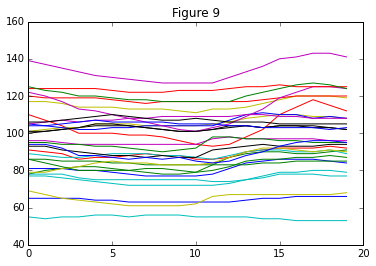

In [60]:
# select 30 objects randomly which have standard deviation > threshold
# Extract random subset of records, filtering on a summary statistic.
examples = series_data.filter(lambda x: x.std() > 1.0).sample(30)
# only plot first 20 states of each object
plt.plot(np.array(examples).T)
plt.title("Figure 9")
plt.show()

<div class="alert alert-success">  
Here we see some voxels with a standard deviation above 1, which means some ov them vary just a little, and some others vary quite a lot.
<br><br>
Let's see set both un upper and a lower bound.
</div>

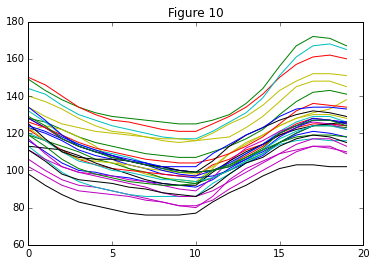

In [61]:
examples = series_data.filter(lambda x: x.std() > 10 and x.std() < 20 ).sample(30)
plt.plot(np.array(examples).T)
plt.title("Figure 10")
plt.show()

<div class="alert alert-success">  
As already mentioned above, some voxels have this kind of sine wave behaviour. It would be interesting to know when the stimulus was presented to the fish at time of recording these images so as to understand how neurons respond in time: some of them may fire immediately, others may light up later as reported <a href="http://research.janelia.org/zebrafish/pca.html">here</a>.
</div>

### d. Preprocessing Series data
A `Series` object has some methods which can be useful in an eventual preprocessing phase.

For example, `center` subtracts the mean, `normalize` subtracts and divides by a baseline (either the mean, or a percentile).

In [62]:
examples

Series
mode: local
dtype: uint8
shape: (30, 20)

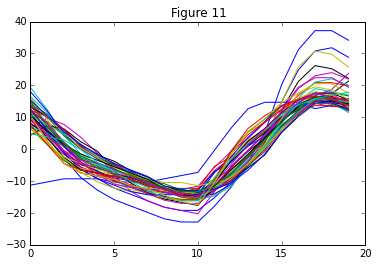

In [63]:
examples = series_data.center().filter(lambda x: x.std() >= 10).sample(50)
plt.plot(np.array(examples).T)
plt.title("Figure 11")
plt.show()

<div class="alert alert-success">  
Here we have the time behaviour of voxels with standard deviation above 10, but they're centered around zero.
</div>

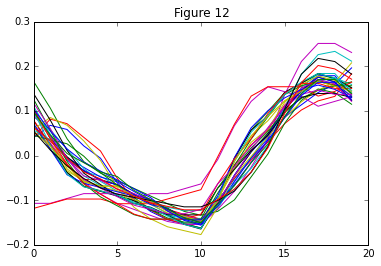

In [64]:
normalizedRDD = series_data.normalize(method='mean').filter(lambda x: x.std() >= 0.1).sample(50)
plt.plot(np.array(normalizedRDD).T)
plt.title("Figure 12")
plt.show()

<div class="alert alert-success">  
Here we first normalize our data, which means we now deal with smaller standard deviation values, then we select some of the voxels with a standard deviation above 0.1. From these last two figures we see that some neurons acted differently, i.e., they were slowly increasing their activity while the majority was "swithing off". 
</div>

### e. Computing statistics about Series data
A `Series` can be summarized with statistics both within and across images. To summarize **across records** (the statistic of all voxels at each timestamp), we can do the following:

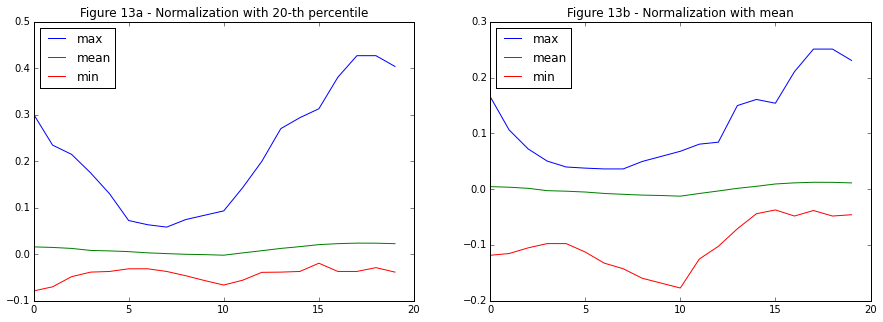

In [65]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(series_data.normalize().max(), label="max");
plt.plot(series_data.normalize().mean(), label="mean");
plt.plot(series_data.normalize().min(), label="min");
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=0)
plt.title("Figure 13a - Normalization with 20-th percentile")

plt.subplot(122)
plt.plot(series_data.normalize(method='mean').max(), label="max");
plt.plot(series_data.normalize(method='mean').mean(), label="mean");
plt.plot(series_data.normalize(method='mean').min(), label="min");
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=0)
plt.title("Figure 13b - Normalization with mean")
plt.show()

<div class="alert alert-success">  
So, normalizing the voxels, taking the `max()`, the `min()` and the `mean()` and plotting them against the time gives us an idea of our dataset, its evolution and the possible range that a single voxel can have at a certain time. 
<br>
We were curious to see whether normalizing with the mean or with the 20-th percentile gives us different results. Dividing by the mean yields more irregular curves.  

</div>

To summarize **within records**, we can use the `map` method:

In [66]:
means = series_data.map(lambda x: x.mean())
flat_means = means.flatten().toarray()
flat_stdevs = stdevs = series_data.map(lambda x: x.std()).flatten().toarray()
print("means:", flat_means)
print("length of means:", len(flat_means))
print("mean of the first series:", flat_means[0])
print("standard deviation of the first series:", flat_stdevs[0])

means: [ 25.8   25.85  25.7  ...,  26.    26.    26.  ]
length of means: 13224
mean of the first series: 25.8
standard deviation of the first series: 0.4


`means` is now a `Series` object, where the value of each record is the mean across the time series for that voxel.

Note that in the source code above, we use function `toarray` to return all records to the driver as a numpy array.

For this `Series`, since the keys correspond to spatial coordinates, we can `pack` the results back into a local array in **driver node**.


To look at this array as an image, we can use function `draw_image` as before.

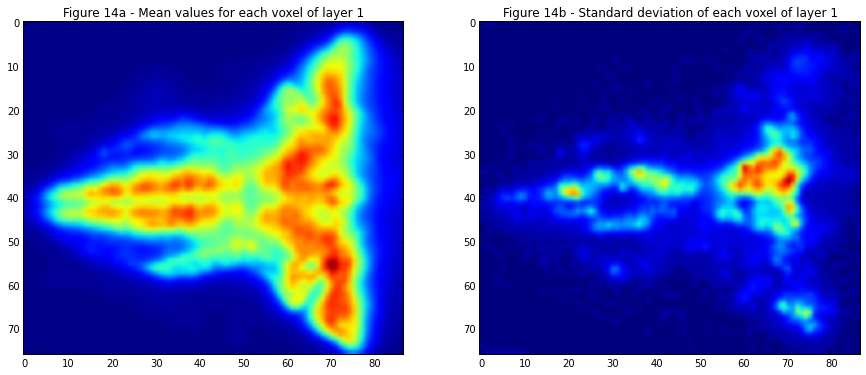

In [67]:
# we should recover the shape of means before plotting
# draw the standard deviations of series that belong to the first layer

layer = 0
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(flat_means.reshape((2, 76, 87)) [layer,:,:], interpolation='gaussian', aspect='equal')
plt.title("Figure 14a - Mean values for each voxel of layer %d" % (layer+1))
plt.subplot(122)
plt.imshow(flat_stdevs.reshape((2, 76, 87)) [layer,:,:], interpolation='gaussian', aspect='equal')
plt.title("Figure 14b - Standard deviation of each voxel of layer %d" % (layer+1))
plt.show()


<div class="alert alert-success">
By looking at these figures we see that almost half of the voxels do not belong to the brain. In Figure 14a we see which regions of the brain are active and we see some sort of symmetry in the hemispheres. Focusing on Figure 14b, we see that most of the brain voxels have a low standard deviation (colored in blue), whereas voxels with a significant standard deviation are clustered in one big region, with red pixels, and some others with yellow pixels. 
</div>

Note that `toarray` is an example of a local operation, meaning that all the data involved will be sent to the Spark driver node. In this case, packing the mean is no problem because its size is quite small. But for larger data sets, this can be **very problematic**. So, it's a good idea to downsample, subselect, or otherwise reduce the size of your data before attempting to pack large image data sets! 

### f. Identifying correlations

In several problem domains, it may also be beneficial to assess the similarity between a designated signal (time series) and another signal of interest by measuring their correlation. For example, say we have two time series corresponding to the consumption of Coca Cola and Pepsi, it would perhaps be interesting to verify whether behavioural patterns are similar for both brands over time.<br>

Simply as a proof of concept, we shall compare our data to a random signal and we expect that, for a random signal, the correlation should be low. The signal can be stored as a numpy array or a MAT file containing the signal as a variable. Note that the size of the signal must be equal to the size of each `Series` element.

In [68]:
from numpy import random
signal = random.randn(len(first_series))
print("The correlation of the first element with random signal:" , series_data.correlate(signal).first())

first_element = series_data.first()
corr = series_data.correlate(np.array(first_element)).first()
print("The correlation of the first element with itselft:", corr)

The correlation of the first element with random signal: [-0.41225547]
The correlation of the first element with itselft: [ 1.]


<div class="alert alert-success">
<i>First element</i> in the cell above is the voxel of layer 1 at position $(x=0,y=0)$.
</div>

# 3. Usecase

## 3.1. Context
Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

In this notebook,  we use K-Means, a well known clustering algorithm which is also familiar to you, as it was introduced during the last lecture on anomaly detection.

## 3.2 Data
The dataset we will use is the time series data which we played with in the previous section. Refer to section 2 if you want to duplicate the code to load such data.

## 3.3.  Building model
### a. Importing required modules

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans, KMeansModel
from sklearn.cluster import KMeans as sklKMeans
from matplotlib.colors import ListedColormap

### b. Loading & inspecting the data

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Load example series data from `fish`, then normalize and cache it to speed up repeated queries. Print the dimensional information of the loaded data.

</div>

```python
####!@SOLUTION@!####
# we must normalize it to get best clustering
data = td.....normalize()

# cache it to speed up related queries
data.cache()

# check the dimensions of data
print (...)
```

In [4]:
data = td.images.fromexample('fish', engine=sc).toseries().normalize()
data.repartition(12)
data.cache()
print (data.shape)

(2, 76, 87, 20)


<div class="alert alert-success">
As starting point, we splitted the data into 12 different partitions as the number of available cores is 12. Due to the small dimension of the dataset we're working on, it might be useful to reduce the partition to avoid unuseful fragmentation. Further analysis will be done afterwards.
<br>
The normalization method by default uses the percentile method at 20%.  
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">
When studying the properties of large data set, we often take a small fraction of it. We have many strategies to select this subset, such as selecting randomly, selecting elements that has the standard deviation bigger than a threshold, or mixing the conditions.  

In this notebook, we will use the second method as a small demonstration.

<ul></ul>

In order to choose a good value for the threshold of standard deviation, we should compute the stddev of each series and plot a histogram of a 10% sample of the values.

<ul></ul>

Complete the source code below to compute the standard deviation of series in data. Plot the histogram of it and discuss it in details. In your opinion, what should be the best value for the threshold ?

</div>

```python
# calculate the standard deviation of each series
# then select randomly 10% of value to plot the histogram
stddevs = (data
           ...
           ...
          )

# plot the histogram of 20 bins
plt....
plt.show()

```

In [87]:
data_count = data.count()
print(data_count)

13224


In [88]:
# calculate the standard deviation of each series
# then select randomly 10% of value to plot the histogram
stddevs = (data.map(lambda x: x.std())\
           .sample(int(data_count/10))\
           .toarray()
          )

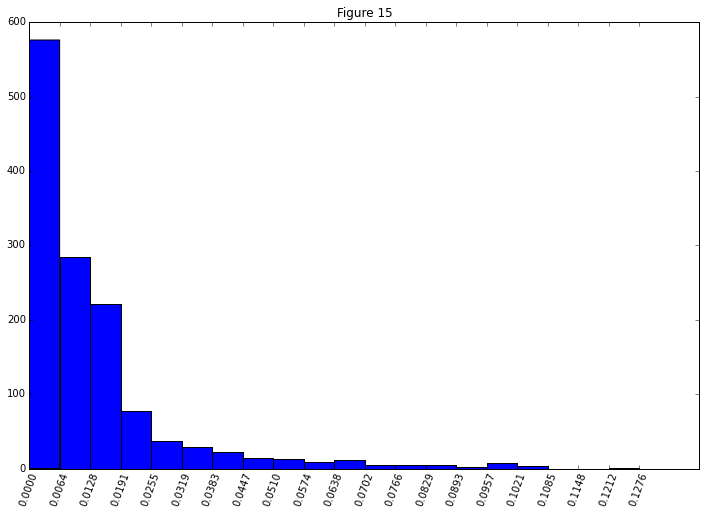

In [89]:
# plot the histogram of 20 bins
plt.figure(figsize=(12,8))
xlabels = plt.hist(stddevs, bins=20)[1]
plt.title("Figure 15")
plt.xticks(xlabels, rotation=70)
plt.show()

<div class="alert alert-success">
Considering also the results and comments of Figure 14b, we think it's appropriate to remove at least 50% of the data which accounts for the background voxels, then we have a 30% of the brain that is inactive or almost inactive for the time frame we consider and we consider it as not useful for our analysis. Recalling that the size of our dataset is 13224, we should remove ~10000 points. Considering the graph above where we have 10% of the data, we should drop ~1000 samples. We decide to set the threshold to  ~0.013.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9

<div class="alert alert-info">

Extract some samples just to look at the typical structure of the time series data.
The objects are selected randomly, and has the standard deviation bigger than the threshold which you picked in question 8.
Plot the samples and discuss your obtained figure.

</div>

```python
# sample 50 objects of the data randomly base on the standard deviation
examples = data....

# plot the sample data
plt.plot(...)
plt.show()

```

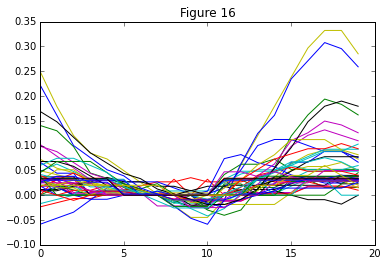

In [90]:
# sample 50 objects of the data randomly base on the standard deviation
threshold = 0.013
examples = data.filter(lambda x : x.std() > threshold).sample(50)

# plot the sample data
plt.plot(np.array(examples).T)
plt.title("Figure 16")
plt.show()


<div class="alert alert-success">
Here we see the time behaviour of 50 voxels with a standard deviation above our threshold. As expected, most of them fluctuate around zero, whereas just a bunch of them show a more dynamic trend. By selecting a higher threshold we would have less voxels around zero.
</div>

### c. Clustering series
In this section, we will use K-means to cluster the series. In other words, we cluster the voxels based on the their behavior. Currently, we have no clue about how many groups `K` of neural behavior. To this end, instead of choosing a single value K, we use multiple values, build model with each `K` and compare the resulting error values. After that, we can choose the best value of `K`. 

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Complete the source below to build multiple models corresponding to multiple values of `K` using algorithm KMeans of Thunder.  

a) Comment the structure of the code. Precisely, focus on the `for` loop, and state what is parallel and what is not.  

b) Can you modify the structure of the code such that you use the most of the parallelization capabilities of Spark?  

</div>

```python
# declare the possible values of K
ks = [5, 10, 15, 20, 30, 50, 100, 200]

# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1]) ).cache()
    
def buildModels(data):
    # declare the collection of models
    models = [] 

    # build model for each K and append to models
    for k in ks:    
        models.append(KMeans(...).fit(...)) 
    return models

models = buildModels(data)
```

In [14]:
def buildModels(data, debug=True):
    # declare the collection of models
    models = [] 

    # build model for each K and append to models
    for k in ks: 
        ti = time()
        models.append(KMeans.train(data, k)) 
        print("k = %d, training time = %.2f" %(k, (time()-ti))) if debug else 0
    return models

In [10]:
# declare the possible values of K
ks = [5, 10, 15, 20, 30, 50, 100, 200]

In [124]:
# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1]) ).repartition(12).cache()
t0 = time()
models = buildModels(training_data)
print("Total time = %.2f" % (time()-t0))

k = 5, training time = 0.94
k = 10, training time = 4.69
k = 15, training time = 2.06
k = 20, training time = 2.27
k = 30, training time = 3.04
k = 50, training time = 2.91
k = 100, training time = 3.44
k = 200, training time = 2.17
Total time = 21.52


<div class="alert alert-success">
Now that we massively start to use the dataset, it interesting to analyse how performance increases or degradates as the number of partitions changes.
</div>

In [69]:
data.uncache()
training_data.unpersist()
for i in range(1, 25):
    training_data = data.tordd().map(lambda x: np.array(x[1]) ).repartition(i)
    t0 = time()
    models = buildModels(training_data, False)
    print("Number of partitions: %d  \tTotal time = %.2f" % (training_data.getNumPartitions(), (time()-t0)))

Number of partitions: 1  	Total time = 32.07

Number of partitions: 2  	Total time = 26.79

Number of partitions: 3  	Total time = 28.56

Number of partitions: 4  	Total time = 24.36

Number of partitions: 5  	Total time = 24.16

Number of partitions: 6  	Total time = 23.22

Number of partitions: 7  	Total time = 32.23

Number of partitions: 8  	Total time = 28.36

Number of partitions: 9  	Total time = 29.93

Number of partitions: 10  	Total time = 30.11

Number of partitions: 11  	Total time = 29.63

Number of partitions: 12  	Total time = 28.99

Number of partitions: 13  	Total time = 33.22

Number of partitions: 14  	Total time = 32.73

Number of partitions: 15  	Total time = 34.55

Number of partitions: 16  	Total time = 37.88

Number of partitions: 17  	Total time = 33.46

Number of partitions: 18  	Total time = 37.74

Number of partitions: 19  	Total time = 43.35

Number of partitions: 20  	Total time = 36.05

Number of partitions: 21  	Total time = 37.94

Number of partitions: 

<div class="alert alert-success">
Our use case is very particular as the number of samples is not massive. The time for performing the training of the KMeans algorithm suggests that the optimal number of partition should be less (6) than the one (12) we proposed before.
</div>

<div class="alert alert-success">
Let's try to increase the parallelism using the strength of Spark. Our idea was to parallelise the training with different models (e.g. different k); unfortunately, the current implementation of KMeans in MLlib does not allow to broadcast an RDD without collect it into a list/numpy array (issue still one here https://issues.apache.org/jira/browse/SPARK-1486). For this reason, we moved to distributed training of different models with a local implementation of the clustering algorithm (notably sklearn).
</div>

In [46]:
def buildModels2(data):
    bData = sc.broadcast(data.collect())
    models = ks_rdd.map(lambda k: sklKMeans(k).fit(bData.value))
    return models.collect()  

In [50]:
ks_rdd = sc.parallelize([5, 10, 15, 20, 30, 50, 100, 200, ], 8)
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()

t0 = time()
models = buildModels2(training_data)
print("Total time = %.2f" % (time()-t0))

Total time = 13.57


In [54]:
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()

# Unseful train, just to make the training data cached
KMeans.train(training_data, 10)
for i in range(1, 9):
    ks_rdd = sc.parallelize([5, 10, 15, 20, 30, 50, 100, 200, ], i)
    t0 = time()
    models = buildModels2(training_data)
    print("Number of partitions: %d  \tTotal time = %.2f" % (i, (time()-t0)))

Number of partitions: 1  	Total time = 26.91
Number of partitions: 2  	Total time = 21.88
Number of partitions: 3  	Total time = 22.02
Number of partitions: 4  	Total time = 15.90
Number of partitions: 5  	Total time = 17.69
Number of partitions: 6  	Total time = 18.52
Number of partitions: 7  	Total time = 19.53
Number of partitions: 8  	Total time = 13.90


<div class="alert alert-success">  
It's not a surprise here that the fastest implemenation is the one with number of partitions equal to the number of different models we want to train: in this way, each training is binded to a single core and the whole process gains the highest speedup.
</div>

### d. Testing models & choosing the best one

Next, we evaluate the quality of each model. We use two different error metrics on each of the clusterings. 

* The first is the sum across all time series of the Euclidean distance from the time series to their cluster centroids. 

* The second is a built-in metric of the `KMeansModel` object.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11

<div class="alert alert-info">  

a) Write function `model_error_1` to calculate the sum of Squared Euclidean Distance from the Series objects to their clusters centroids.  

b) Comment the choice of the error function we use here. Is it a good error definition?

</div>

```python
from scipy.spatial.distance import cdist

# calculate the Euclidean distance
# from each time series to its cluster center
# and sum all distances
def model_error_1(data, model):
    ...
    return data....
```

In [94]:
from scipy.spatial.distance import cdist

# calculate the Euclidean distance
# from each time series to its cluster center
# and sum all distances
def model_error_1(data, model):
    errors = data.map(lambda x: cdist([x], [model.centers[model.predict(x)]], metric='sqeuclidean'))
    return errors.sum()[0][0]

<div class="alert alert-success">  
When projecting each voxel into the 20-dimensional space, voxels with similar intensity would be placed close to each other, regardless of their behaviour in time. If two voxels have different intensity, but respond to a stimulus in the same way (when one increases, so does the other) they would be places far apart. To take this aspect into account it would be better to use 19 features, each one representing the derivative with respect to the time at each timestep (difference between state at time $i$ and state at time $i-1$). In this way, voxels which have similar trends in time would be placed closer to each other.
<br><br>
A part from this, when using this error function, if we increase $k$, the error would decrease, meaning that we should increase $k$ up to the number of input data points, hence we end up with very small clusters and we are not able to appreciate their groupings anymore. This can be considered as overfitting.
<br>With the Euclidean distance we are limited to spherical clusters and maybe they do not fit our data. 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

a) Write function `model_error_2` to calculate the total of similarity of `Series` objects based on how well they match the cluster they belong to, and then calculate the error by inverse the total similarity.  

b) Similarly to the previous question, comment the choice of the similarity function.  

</div>

```python
# calculate the total of similarity of the model on timeseries objects
# and calculate the error by inverse the total similarity

# Estimate similarity between a data point and the cluster it belongs to.
def similarity(centers, p):
    if np.std(p) == 0:
        return 0
    return np.corrcoef(centers[np.argmin(cdist(centers, np.array([p])))], p)[0, 1]


def model_error_2(data, model):
    return 1. / ...
```

In [95]:
# calculate the total of similarity of the model on timeseries objects
# and calculate the error by inverse the total similarity

# Estimate similarity between a data point and the cluster it belongs to.
def similarity(centers, p):
    if np.std(p) == 0:
        return 0
    return np.corrcoef(centers[np.argmin(cdist(centers, np.array([p])))], p)[0, 1]


def model_error_2(data, model):
    return 1.0 / data.map(lambda p: similarity(model.centers, p)).reduce(lambda a,b: a+b)

<div class="alert alert-success">  
The `np.corrcoef()` function returns Pearson product-moment correlation coefficients. 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Plot the error of the models along with the different values of K in term of different error metrics above. From the figure, in your opinion, what is the best value for `K` ? Why ?

</div>

```python
def testAndPlotTheResult(data, models):
    # compute the error metrics for the different resulting clusterings
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray(...)
    
    # error of models when using similarity
    errors_2 = np.asarray(...)

    # plot the errors with each value of K
    plt.plot(
        ks, errors_1 / errors_1.sum(), 'k-o',
        ks, errors_2 / errors_2.sum(), 'b:v')
    plt.show()
    
testAndPlotTheResult(training_data, models)
```

In [96]:
def testAndPlotTheResult(data, models, figNumber):
    """compute the error metrics for the different resulting clusterings"""
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_1(data, model) for model in models])
    
    # error of models when using similarity
    errors_2 = np.asarray([model_error_2(data, model) for model in models])

    # plot the errors with each value of K
    plt.figure(figsize=(10,5))
    plt.title("Figure %d" % figNumber)
    plt.plot(
        ks, errors_1 / errors_1.sum(), 'k-o',
        ks, errors_2 / errors_2.sum(), 'b:v')
    plt.show()

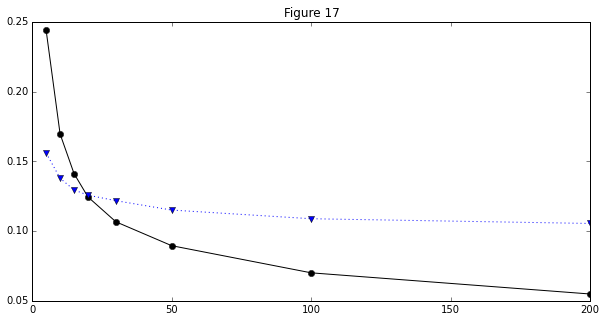

In [125]:
testAndPlotTheResult(training_data, models, 17)

<div class="alert alert-success">
With the Euclidean distance we overfit to our training data as the error converges to zero as $k$ increases. With the inverse of the similarity instead we get a more useful indication of when to stop increasing $k$. We think a good value of k is between 10 and 20, because from those values on the inverse of the similarity does not decrease significantly. Our first choice is 15.
</div>

Determining the optimal $k$ is particularly troublesome for the $k$-Means algorithm because error measures based on distance decrease monotonically as $k$ increases. This arises because when $k$ is increased, each cluster is decomposed into more and more clusters, such that each point becomes closer to its cluster mean. In fact, in the extreme case where $k=N$, each point will be assigned to its own cluster, and all distances are reduced to nil. Cross-validation or using holdout data is also unlikely to be particularly effective in this case.<br>

To this end, it is often worth assessing a model by measuring its impact on the overall aim of carrying out the clustering. For example, if we are carrying out $k$-means for grouping customers having similar taste and purchase history with the ultimate intent of making recommendations to customers, our objective function should measure how effective the recommendations are (perhaps using holdout data). An appealing aspect of using such a metric is that it is no longer guaranteed to behave monotonically with respect to $k$. We shall investigate this further in Question 20.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Plot the centroids of the best model. Do you think that the result is good ?

</div>

```python
# plot the best performing model
bestModel = models[...]
plt.plot(...)
plt.show()
```

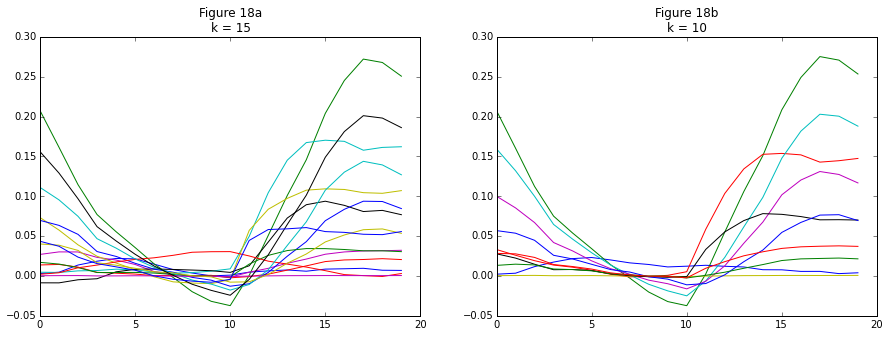

In [126]:
# plot the best performing model
plt.figure(figsize=(15,5))
plt.subplot(121)
k_index = 2
bestModel = models[k_index]
plt.title("Figure 18a \nk = %d" %ks[k_index])
plt.plot(np.asarray(bestModel.centers).T)
# plt.show()
k_index = 1
plt.subplot(122)
bestModel = models[k_index]
plt.title("Figure 18b \nk = %d" %ks[k_index])
plt.plot(np.asarray(bestModel.centers).T)
plt.show()

<div class="alert alert-success">
We decided to plot two models to see how the centroids were chosen because they will play a key role in clustering. We think that to choose the best value of $k$ we need the results of both Figure 17 and 18. The first gives us a possible range for $k$, while the second can help us in choosing the final value. Figure 18a shows us that with $k = 15$ we have some similar centroids (the ones that fluctuate around zero) and they sould be joined in one centroid. This problem is less evident in Figure 18b where we decrease the number of clusters.
Both figures though reveal that we do not have centroids to represent extreme values, i.e. red and blue lines in Figure 13a.
<br><br>
To summarize, we are pretty satisfied with the result in Figure 18b as we think it reacheas a good trade-off between number of clusters and internal cohesion. 
</div>

### e. Visualizing the result
We can also plot an image of labels of neurons, such that we can visualize the group of each neuron.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 15

<div class="alert alert-info">

Complete the source code below to visualize the result of clustering.

</div>

```python
# predict the nearest cluster id for each voxel in Series
labels = bestModel.predict(...)

# collect data to the driver
imgLabels = labels...

# consider the voxel of the first layers
draw_image(imgLabels[:,:,0])
```

In [127]:
# predict the nearest cluster id for each voxel in Series
interp = 'spline36'
k_index = 1

# consider the voxel of the first layers
labels = data.map(lambda x: bestModel.predict(x))

# collect data to the driver
imgLabels = labels.toarray().reshape(2, 76, 87)

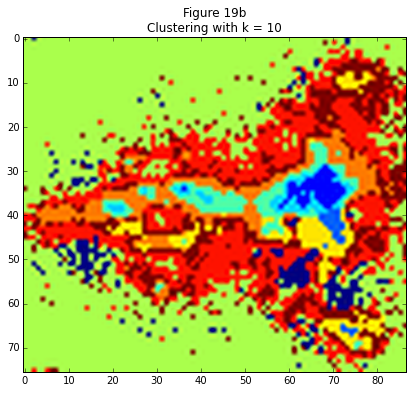

In [128]:
plt.figure(figsize=(12,6))
plt.imshow(imgLabels[0,:,:], interpolation=interp, aspect='equal')
plt.title("Figure 19b \nClustering with k = %d " % ks[k_index])
plt.show()

<div class="alert alert-success">  
Following the comment to Figure 18, we used $k = 10$, so as to avoid having lots of centroids for inactive or almost inactive regions. We think Figure 19 is pretty similar to the hindbrain in Figure 14b and the most active regions, blue and light blue, have been clustered together. This tells us that most of the patterns have been captured quite well.
</div>

<div class="alert alert-success">
Another useful image presented in [2] is shown in Figure 20a, where again we observe that the clusters in Figure 19b are in accordance in the tectum region, in the neurons associated to alx protein and in the lateral neuropil as well.
</div>

<p style="text-align: center;">Figure 20</p>
![alt text](http://www.nature.com/nmeth/journal/v11/n9/images_article/nmeth.3041-F5.jpg)
<div class="alert alert-success">
Maps of sensorimotor responses in larval zebrafish. (a) Maps of response dynamics obtained by reducing each voxel to a pair of numbers using PCA. (b) Stimulus sequence and calcium responses of individual neurons; examples highlight different response types. (c) Map derived from an experiment in which the fish swam sporadically in response to a
constantly slowly moving stimulus. (d) Swimming strength and calcium responses of individual neurons during self-driven swimming.
</div>

With the default color scheme, this figure is quite difficult to understand and to distinguish the groups according to their similar colors. So, we should have a smater color selection. The fact is, when we do clustering, it is often the case that some centers are more similar to one another, and it can be easier to interpret the results if the colors are choosen based on these relative similarities. The method `optimize` tries to find a set of colors such that similaries among colors match similarities among an input array (in this case, the cluster centers). The optimization is non-unique, so you can run multiple times to generate different color schemes.

In [11]:
from numpy import arctan2, sqrt, pi, abs, dstack, clip, transpose, inf, \
    random, zeros, ones, asarray, corrcoef, allclose, maximum, add, multiply, \
    nan_to_num, copy, ndarray, around, ceil, rollaxis

# these functions below are inspired mainly from Thunder-Project source code, v.0.6
# url: https://raw.githubusercontent.com/thunder-project/thunder/branch-0.6/thunder/viz/colorize.py

# Optimal colors based on array data similarity.
def optimize_color(mat):
        mat = np.asarray(mat)

        if mat.ndim < 2:
            raise Exception('Input array must be two-dimensional')

        nclrs = mat.shape[0]

        from scipy.spatial.distance import pdist, squareform
        from scipy.optimize import minimize

        distMat = squareform(pdist(mat, metric='cosine')).flatten()

        optFunc = lambda x: 1 - np.corrcoef(distMat, squareform(pdist(x.reshape(nclrs, 3), 'cosine')).flatten())[0, 1]
        init = random.rand(nclrs*3)
        bounds = [(0, 1) for _ in range(0, nclrs * 3)]
        res = minimize(optFunc, init, bounds=bounds, method='L-BFGS-B')
        newClrs = res.x.reshape(nclrs, 3).tolist()

        from matplotlib.colors import ListedColormap

        newClrs = ListedColormap(newClrs, name='from_list')

        return newClrs

# Blend two images together using the specified operator.
def blend(img, mask, op=add):
        if mask.ndim == 3:
            for i in range(0, 3):
                img[:, :, :, i] = op(img[:, :, :, i], mask)
        else:
            for i in range(0, 3):
                img[:, :, i] = op(img[:, :, i], mask)
        return img

def _prepareMask(mask):
        mask = asarray(mask)
        mask = clip(mask, 0, inf)

        return mask / mask.max()
    
# Colorize numerical image data.
def transform(cmap, img, mask=None, mixing=1.0):
        from matplotlib.cm import get_cmap
        from matplotlib.colors import ListedColormap, LinearSegmentedColormap, hsv_to_rgb, Normalize

        img = asarray(img)
        dims = img.shape

        if cmap not in ['polar', 'angle']:

            if cmap in ['rgb', 'hv', 'hsv', 'indexed']:
                img = copy(img)
                for i, im in enumerate(img):
                    norm = Normalize(vmin=None, vmax=None, clip=True)
                    img[i] = norm(im)

            if isinstance(cmap, ListedColormap) or isinstance(cmap, str):
                norm = Normalize(vmin=None, vmax=None, clip=True)
                img = norm(copy(img))

        if mask is not None:
            mask = _prepareMask(mask)

        if isinstance(cmap, ListedColormap):
            if img.ndim == 3:
                out = cmap(img)
                out = out[:, :, :, 0:3]
            if img.ndim == 2:
                out = cmap(img)
                out = out[:, :, 0:3]
        else:
            raise Exception('Colorization method not understood')

        out = clip(out, 0, 1)

        if mask is not None:
            out = blend(out, mask, multiply)

        return clip(out, 0, 1)

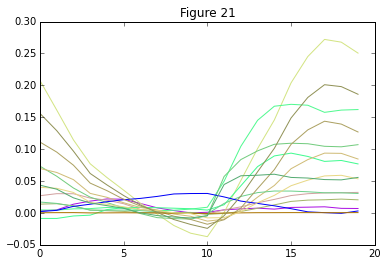

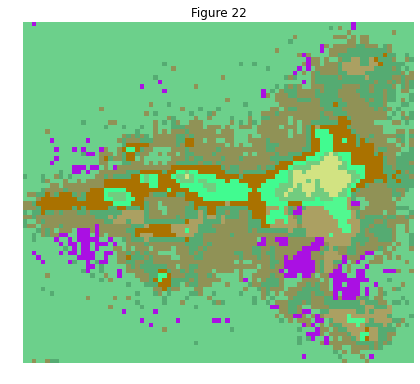

In [130]:
k_index = 2 # ks = [5, 10, 15, 20, 30, 50, 100, 200]
# generate the better color scheme
bestModel = models[k_index]
newClrs = optimize_color(bestModel.centers)
plt.gca().set_color_cycle(newClrs.colors)
plt.title("Figure 21")
plt.plot(np.array(bestModel.centers).T);
# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0,:,:])
img = draw_image(brainmap)
plt.title("Figure 22")
plt.show()

<div class="alert alert-success">
The similarity with Figure 14b is now more evident as the colors are chosen in a more suitable way.
</div>

### f. Improving the result by removing noise
One problem with what we've done so far is that clustering was performed on all time-series without data pre-processing. Many of  time-series objects were purely noise (e.g. those outside the brain), and some of the resulting clusters capture these noise signals. A simple trick is to perform clustering after subselecting pixels based on the standard deviation of their time series. First, let's look at a map of the standard deviation, to find a reasonable threshold that preserves most of the relavant signal, but ignores the noise.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 16

<div class="alert alert-info">

Try with different thresholds of standard deviation to filter the noise. What is the "best value" that preserves most of the relavant signal, but ignores the noise? Why?

</div>

```python
# calculate the standard deviation of each voxel 
# then collect to the driver
stdMap = data....

# here we should try with many different values of threshold 
# and choosing the best one
# visualize the map of the standard deviation after filtering
draw_image(stdMap[0,:,:] > ...)
```

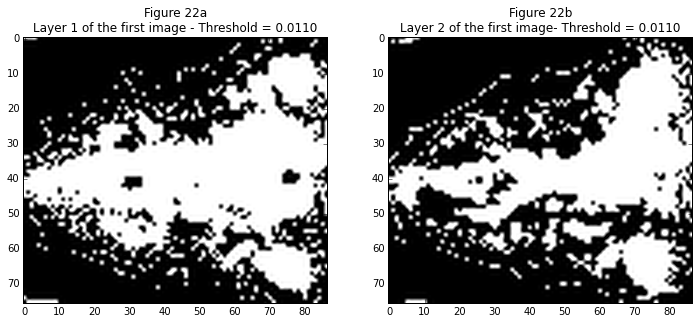

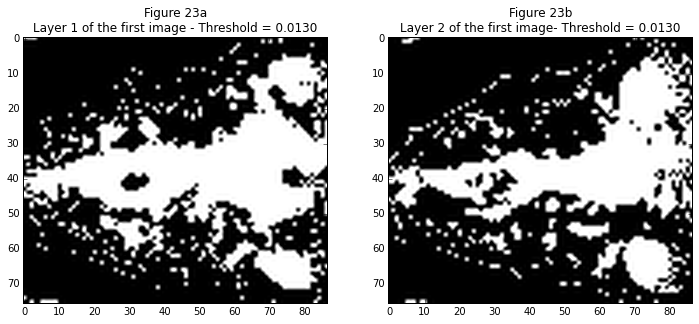

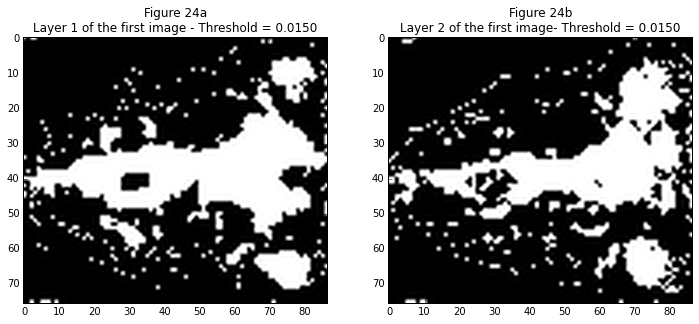

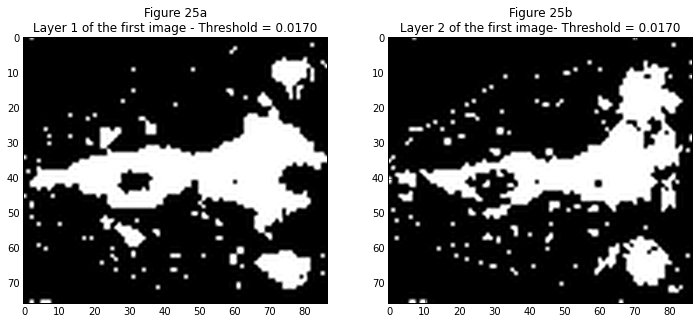

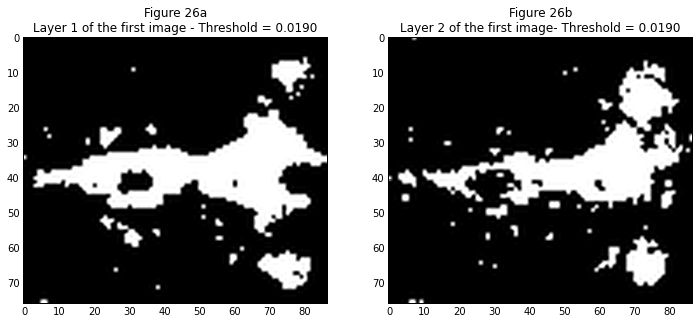

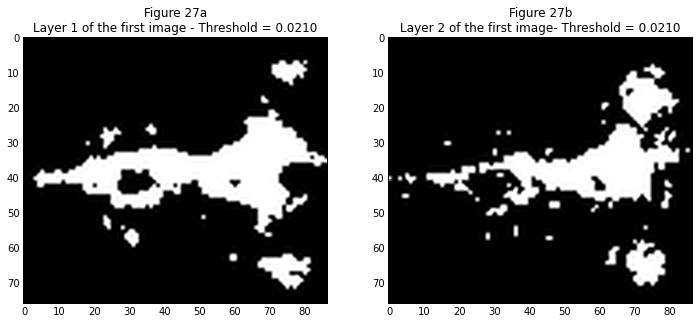

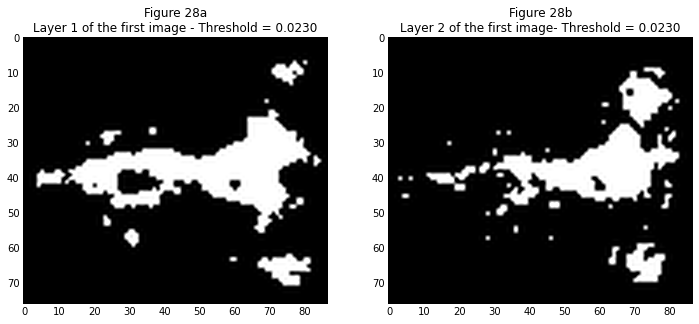

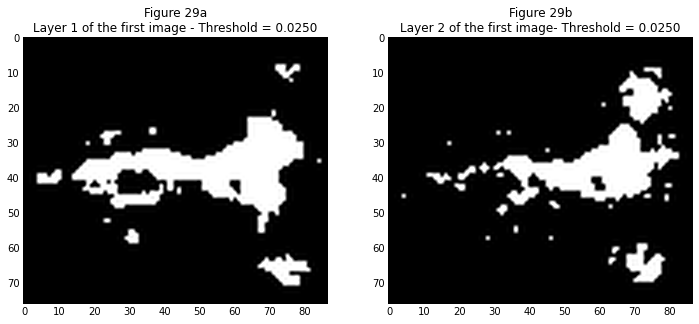

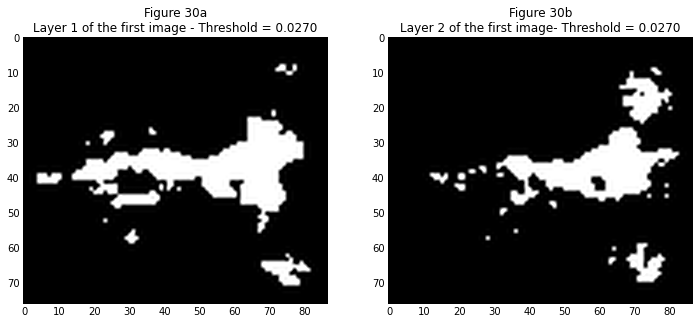

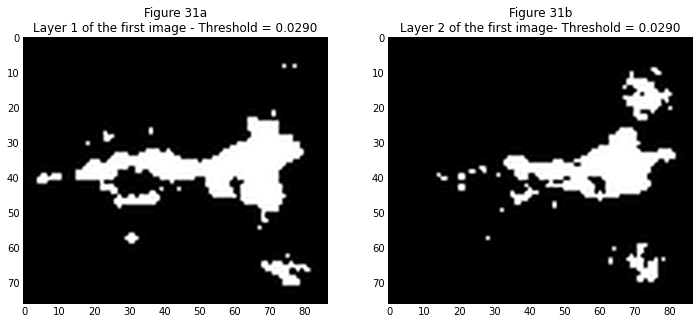

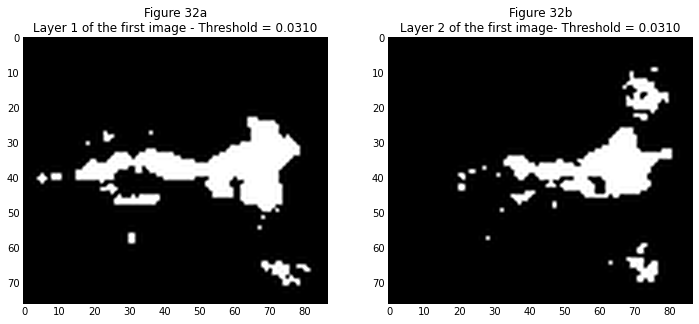

In [131]:
# calculate the standard deviation of each voxel 
# then collect to the driver
stdMap = data.map(lambda x: x.std()).toarray()

# here we should try with many different values of threshold 
# and choosing the best one
# visualize the map of the standard deviation after filtering
thresholds = np.linspace(0.011, 0.031, 11)

n = 21
nlayer = 0
for t in thresholds:
    n +=1
    plt.figure(figsize=(12,6))
#     plt.suptitle("Figure %d" %(n+1))
    plt.subplot(121)
    plt.imshow(stdMap[nlayer,:,:] > t, interpolation=interp, aspect='equal', cmap='gray')
    plt.title("Figure %da\nLayer %d of the first image - Threshold = %.4f" % (n, nlayer+1, t))
    plt.subplot(122)
    plt.imshow(stdMap[nlayer+1,:,:] > t, interpolation=interp, aspect='equal', cmap='gray')
    plt.title("Figure %db\nLayer %d of the first image- Threshold = %.4f" % (n, nlayer+2, t))
    plt.show()

<div class="alert alert-success">
Before this question we picked a threshold of 0.013. Now, with this additional analysis we think a reasonable range is between 0.017 and 0.021. In the first case, we retain a most of the useful information as Figure 25 shows, while with 0.023 we start losing some areas that might in the interesting to represent (Figure 28) and that we consider meaningful signals as shown in Figure 6c. Using 0.019 should be reasonable trade-off. 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 17

<div class="alert alert-info">

Filter your data such that we only keep the voxels that have the standard deviation bigger than the threshold in question 16.

</div>

```python
####!@SOLUTION@!####
from numpy import std
# remove series object that has the standard deviation bigger than a threshold
filtered = data.filter(...).cache()
print(filtered.shape)
```

In [10]:
from numpy import std
threshold = 0.019
# remove series object that has the standard deviation bigger than a threshold
filtered = data.filter(lambda x: x.std() > threshold).cache()
print(filtered.shape)

(2490, 20)


<div class="alert alert-success">
The number of filtered voxels correspond to around 20% of our initial dataset, and it is a reasonable percentage if we want to focus our attention on the most actice neurons we already said. 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 18

<div class="alert alert-info">

Re-train and choose the best models with different values of `K` on the new data.

</div>

```python
models = ...
testAndPlotTheResult(training_data, models)
```

In [141]:
filtered_data = filtered.tordd().repartition(6).map(lambda x: np.array(x[1])).cache()
models = buildModels(filtered_data)

k = 5, training time = 1.52
k = 10, training time = 1.53
k = 15, training time = 2.91
k = 20, training time = 2.13
k = 30, training time = 1.53
k = 50, training time = 1.49
k = 100, training time = 1.32
k = 200, training time = 1.71


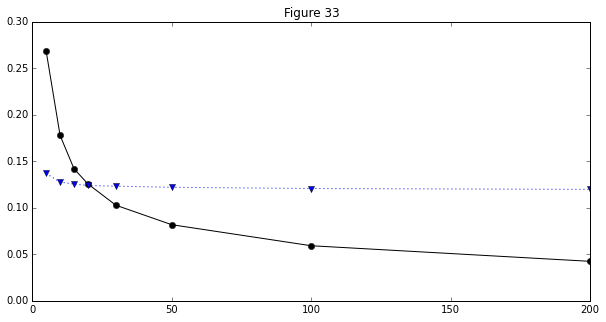

In [142]:
testAndPlotTheResult(filtered_data, models, 33)

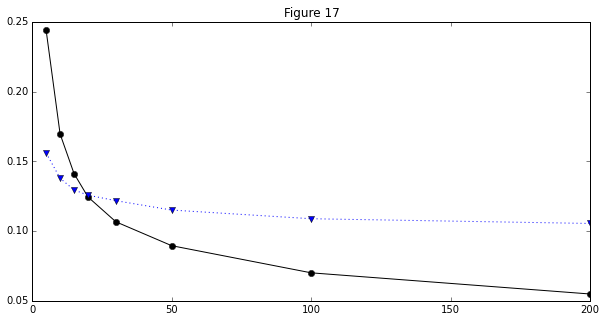

In [125]:
# previous result

<div class="alert alert-success">
Both the error curves are more flat compared to the previous result in Figure 17 as we chose a pretty high threshold on the standard deviation. With a lower threshold we would have got a less flattened behaviour. We set our choice to $k = 10$ which is where the blue curve seems to start flattening.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 19
<div class="alert alert-info">

a) Plot the centroids of the best model with a smart color selection.  

b) Plot the result of the clustering algorithm by a color map of voxels.  

c) Comment about your figures.  
</div>

```python
bestModel = ...
newClrs = ...
...
...
# predict the nearest cluster id for each voxel in Series
labels = data.map(...)

# collect data to the driver
imgLabels = labels....
...
...

draw_image(...)
```

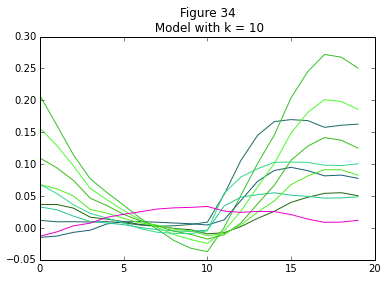

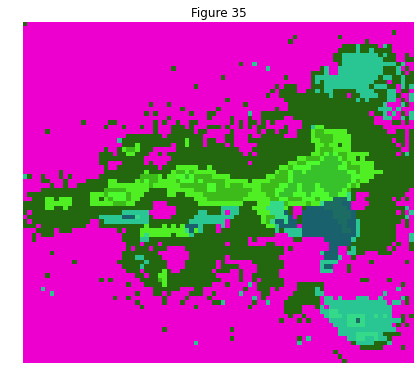

In [145]:
best_k_index = 1
best_k = ks[best_k_index]
bestModel = models[best_k_index]

newClrs = optimize_color(bestModel.centers)
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(np.array(bestModel.centers).T);
plt.title("Figure 34 \n Model with k = %d" %best_k)
# predict the nearest cluster id for each voxel in Series
labels = data.map(lambda x: bestModel.predict(x))

# collect data to the driver
imgLabels = labels.toarray().reshape(2, 76, 87)

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0, :, :])
img = draw_image(brainmap)
plt.title("Figure 35")
plt.show()

<div class="alert alert-success">
By setting a quite high threshold, we are able to classify in a single cluster all the voxels that we consider noise or inactive neurons and they belong to the colored centroid, visible in Figure 35 but also in Figure 34 where the centroid's values are close to zero. 
</div>

### g. Improve the visualization by adding similarity
These maps are slightly odd because pixels that did not survive our threshold still end up colored as something. A useful trick is masking pixels based on how well they match the cluster they belong to. We can compute this using the `similarity` method of `KMeansModel`.

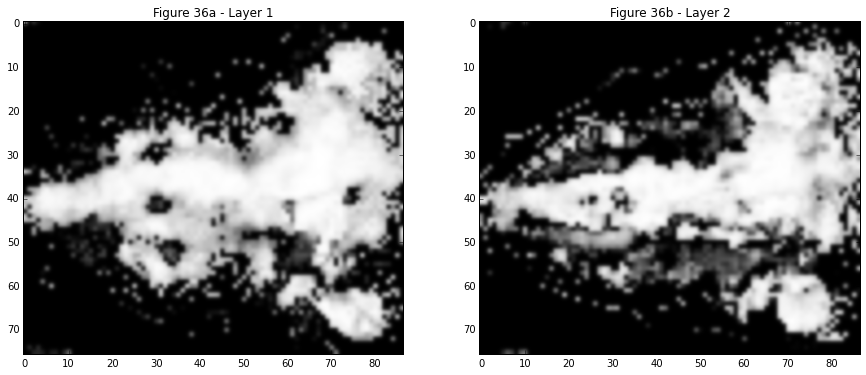

In [146]:
sim = data.map(lambda x: similarity(bestModel.centers, x))

imgSim = sim.toarray()

# draw the mask
# draw_image(imgSim[0,:,:], cmap='gray', clim=(0,1))

layer = 0
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(imgSim[layer,:,:], cmap='gray', interpolation='gaussian', aspect='equal', clim=(0,1))
plt.title("Figure 36a - Layer %d" % (layer+1))
plt.subplot(122)
layer = 1
plt.imshow(imgSim[layer,:,:], cmap='gray', interpolation='gaussian', aspect='equal', clim=(0,1))
plt.title("Figure 36b - Layer %d" % (layer+1))
plt.show()

And, it can be used as a linear mask on the colorization output

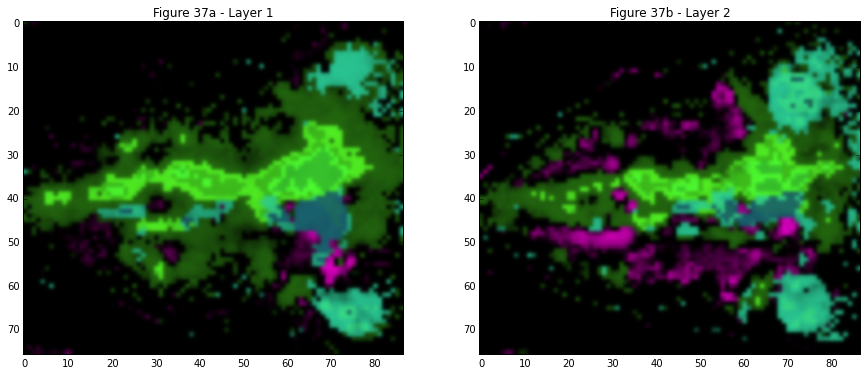

In [147]:
layer = 0
brainmap = transform(newClrs, imgLabels[layer,:,:], mask=imgSim[layer,:,:])
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(brainmap, interpolation='gaussian', aspect='equal')
plt.title("Figure 37a - Layer %d" % (layer+1))
plt.subplot(122)

layer = 1
brainmap = transform(newClrs, imgLabels[layer,:,:], mask=imgSim[layer,:,:])
plt.imshow(brainmap, interpolation='gaussian', aspect='equal')
plt.title("Figure 37b - Layer %d" % (layer+1))
plt.show()

<div class="alert alert-success">
Here we get the same colors and clusters of Figure 35, but we can focus on the voxels that belongs to the brain and are reasonably active.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 20

<div class="alert alert-info">

Since in the usecase we build and test the model from the same data, it can lead to overfitting problems. To avoid that, we can divide the data into training set and testing set. Note that each neuron occurs only one time in the data. So, we can not divide the data by dividing the neurons. Instead, we can divide the states of neurons into two different sets. Let's try with this approach and show the result.

</div>

<div class="alert alert-success">
This notebook is all about the behaviour of the neurons over time. There are at least three different approaches to split our data set along this axis and get our test set: 
<ul>
<li>take samples with even time index, </li>
<li>take 10 random samples between t = 0 and t = 19, </li>
<li>take the first 10 samples.</li>
</ul>
<br>
From the first case we expect to obtain good results on the test set because it will have data points quite similar with the training set. Thanks to the regular sampling we introduce we should be able to track every possible pattern.
In the second case, clustering might be a bit more difficult as the training samples might not represent the whole data set properly.
The third case is the most challenging considering that the behaviour of two neurons might be related from time t = 0 and t = 9 but not between t = 10 and t = 19 as the environment conditions may change.
<br><br>
Notice that it's fundamental to end up with voxels with same size so as to be able to project them into the same space, in our case it will be a 10-dimensional space. We will start with the first option.
</div>

Training Sample
 [ 0.00772201  0.00772201  0.00772201  0.00772201  0.00772201 -0.03088803
  0.00772201  0.00772201  0.00772201  0.00772201]
Filtered training set shape: (6765, 10)
k = 5, training time = 3.62
k = 10, training time = 1.18
k = 15, training time = 1.48
k = 20, training time = 2.43
k = 30, training time = 1.36
k = 50, training time = 2.68
k = 100, training time = 2.52
k = 200, training time = 3.01
Total time = 18.28


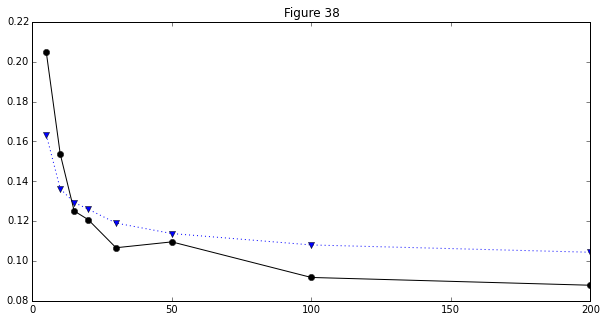

In [149]:
data = td.images.fromexample('fish', engine=sc).toseries().normalize()
data.repartition(12).cache()
#data.cache()
threshold = 0.008 

train_i = [i for i in range(20) if i%2==0]
train_data = data.select(lambda x: x in train_i)
print("Training Sample\n", train_data.first())
filt_train_data = train_data.filter(lambda x: x.std() > threshold)
print("Filtered training set shape:", filt_train_data.shape)
filt_train_data = filt_train_data.tordd().map(lambda x: np.array(x[1])).repartition(6).cache()
t0 = time()
models = buildModels(filt_train_data)
print("Total time = %.2f" % (time()-t0))
test_i = [i for i in range(20) if i%2!=0]
test_data = data.select(lambda x: x in test_i)
test_dataRDD = test_data.tordd().map(lambda x: np.array(x[1])).cache()
testAndPlotTheResult(test_dataRDD, models, 38)

<div class="alert alert-success">
Testing our model on a test set yields more irregular trends. With this last result, choosing $k$ is not straighforward. It seems that $k = 10$ is still a good choice if we consider the inverse of the similarity, but the error based on the euclidean distance seems to suggest higher values.
</div>

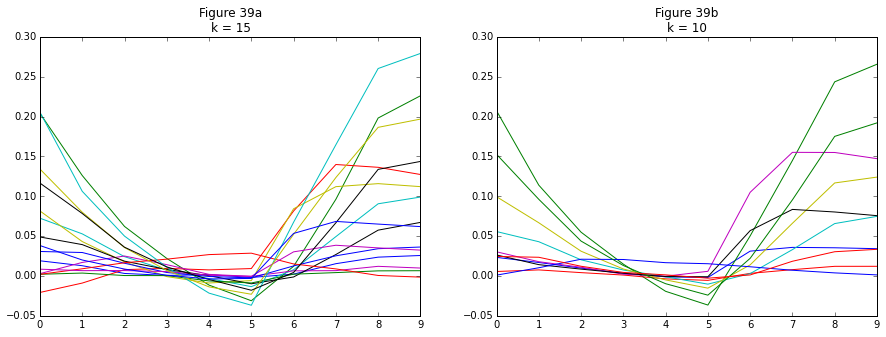

In [150]:
# plot the best performing model
plt.figure(figsize=(15,5))
plt.subplot(121)
k_index = 2
bestModel = models[k_index]
plt.title("Figure 39a \nk = %d" %ks[k_index])
plt.plot(np.asarray(bestModel.centers).T)
# plt.show()
k_index = 1
plt.subplot(122)
bestModel = models[k_index]
plt.title("Figure 39b \nk = %d" %ks[k_index])
plt.plot(np.asarray(bestModel.centers).T)
plt.show()

<div class="alert alert-success">
We think some of the centroids in Figure 39a can be joined together as we have in Figure 39b and still be able to have good clustering results. 
</div>

<div class="alert alert-success">
After splitting our dataset in training set and test set using even and odd time indices, we trained the model on the filtered training data, then we clustered all the test data using the model with 10 centroids. 
<br><br>
We now want to see how clustering errors change when splitting our data set randomly.
</div>

Training Sample
 [ 0.00772201  0.00772201  0.00772201  0.00772201 -0.03088803 -0.03088803
 -0.03088803  0.00772201  0.00772201  0.00772201]
Filtered training set shape: (6741, 10)
k = 5, training time = 2.95
k = 10, training time = 1.49
k = 15, training time = 2.77
k = 20, training time = 2.06
k = 30, training time = 2.04
k = 50, training time = 2.62
k = 100, training time = 2.56
k = 200, training time = 3.22
Total time = 19.71


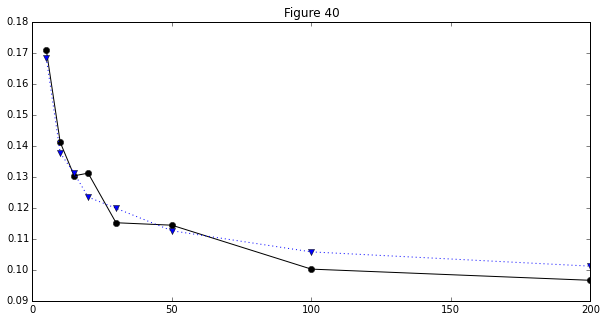

In [155]:
indices = np.arange(20)
np.random.shuffle(indices)
train_i = indices[:10]
test_i = indices[10:]
train_data = data.select(lambda x: x in train_i)
print("Training Sample\n", train_data.first())
filt_train_data = train_data.filter(lambda x: x.std() > threshold)
print("Filtered training set shape:", filt_train_data.shape)
filt_train_data = filt_train_data.tordd().map(lambda x: np.array(x[1])).cache()
t0 = time()
models = buildModels(filt_train_data)
print("Total time = %.2f" % (time()-t0))
test_data = data.select(lambda x: x in test_i)
test_dataRDD = test_data.tordd().map(lambda x: np.array(x[1])).cache()
testAndPlotTheResult(test_dataRDD, models, 40)

<div class="alert alert-success">
By looking at Figure 40 we see that random selection have a bigger impact on these error metrics. Irregularity arises and choosing $k$ is complicated. Training and testing the model multiple times led us to conclude that for this kind of splitting $k = 30$ allows us to avoid overfitting, since it is a good trade-off between error magnitude and number of clusters.
<br><br>
Finally, we'll try to split our data set by using the first 10 time indices for training and the last 10 for testing.

</div>

Training Sample
 [ 0.00772201  0.00772201  0.00772201  0.00772201  0.00772201  0.00772201
  0.00772201 -0.03088803  0.00772201 -0.03088803]
Filtered training set shape: (6182, 10)
k = 5, training time = 3.23
k = 10, training time = 3.97
k = 15, training time = 2.02
k = 20, training time = 1.73
k = 30, training time = 1.98
k = 50, training time = 2.25
k = 100, training time = 2.74
k = 200, training time = 2.99
Total time = 20.93


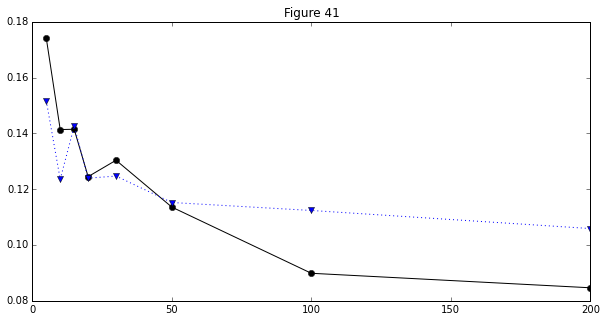

In [157]:
indices = np.arange(20)
train_i = indices[:10]
test_i = indices[10:]
train_data = data.select(lambda x: x in train_i)
print("Training Sample\n", train_data.first())
filt_train_data = train_data.filter(lambda x: x.std() > threshold)
print("Filtered training set shape:", filt_train_data.shape)
filt_train_data = filt_train_data.tordd().map(lambda x: np.array(x[1])).cache()
t0 = time()
models = buildModels(filt_train_data)
print("Total time = %.2f" % (time()-t0))
test_data = data.select(lambda x: x in test_i)
test_dataRDD = test_data.tordd().map(lambda x: np.array(x[1])).cache()
testAndPlotTheResult(test_dataRDD, models, 41)

<div class="alert alert-success">
With this type of splitting, the irregular trend is even more evident, but with $k = 50$ we have almost the same error (inverse of the similarity) of before. 
</div>

<div class="alert alert-success">
If we want to improve the results obtained by k-means we think we need a longer time series to correctly cluster these voxels, as the data set we have does not contain enough general information about the zebrafish brain behaviour. The studies conducted <a href="https://www.youtube.com/watch?v=7mmcEl_1CPw&t=704s">here</a> had 68 million time series on a larger time frame.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 21

<div class="alert alert-info">

Is using K-Means the best choice for a clustering algorithm? Comment the choice and suggest alternatives. For example, look at [Mixture Models](https://en.wikipedia.org/wiki/Mixture_model) and, if you have time, propose an alternative clustering technique. 

</div>

<div class="label label-danger">NOTE</div> Mixture models will be covered in the ASI course in greater detail.

<div class="alert alert-success">
K-Means is not always the best clustering algorithm. K-Means algorithm assigns each point to exactly one cluster (hard assignment), no probabilities are involved. Overlapping clusters represent a problem. K-means leads to clusters that look multivariate Gaussian and since the variance across the variables is the same, K-means leads to clusters that look spherical. Not only do clusters look spherical, but since the covariance matrix is the same across the K groups, K-means leads to clusters that look like the same sphere.
</div>

# Gaussian Mixture Model

<div class="alert alert-success">
The Mixture of Gaussian model helps us to express the uncertainty about a point belonging to a single cluster. It starts with some prior belief about how certain we are about each point's cluster assignments. As it goes on, it revises those beliefs. But it incorporates the degree of uncertainty we have about our assignment. One can think of mixture models as generalising k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.
<br><br>
K-Means tries to find $k$ to minimize $(x-\mu_k)^2$.
<br>
Gaussian Mixture (EM clustering) tries to find $k$ to minimize $\dfrac{(x-\mu_k)^2}{\sigma^2}$, which means GM takes variance into consideration when it calculates the measurement.
<br><br>
We will now try the GMM.
</div>

In [2]:
from sklearn.mixture import GMM

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [5]:
train_data = data.tordd().map(lambda x: np.array(x[1])).cache()

In [6]:
train_data.count()

13224

In [7]:
threshold = 0.019

In [8]:
filtered = data.filter(lambda x: x.std() > threshold).cache()
print(filtered.shape)

(2490, 20)


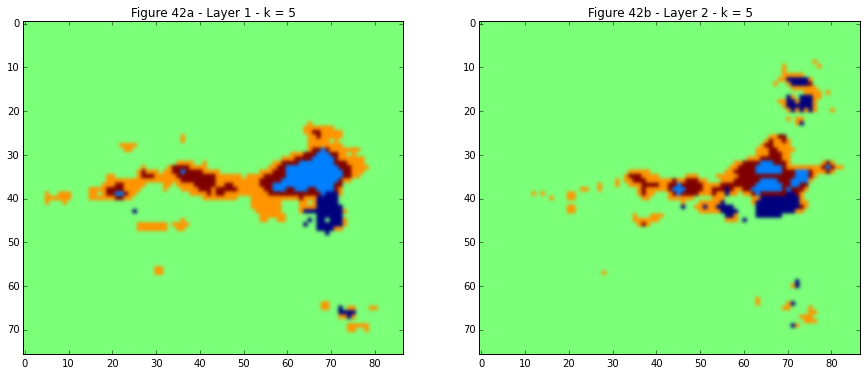

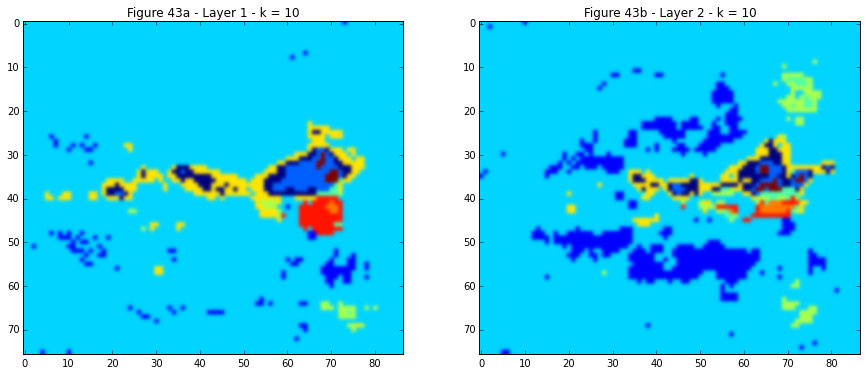

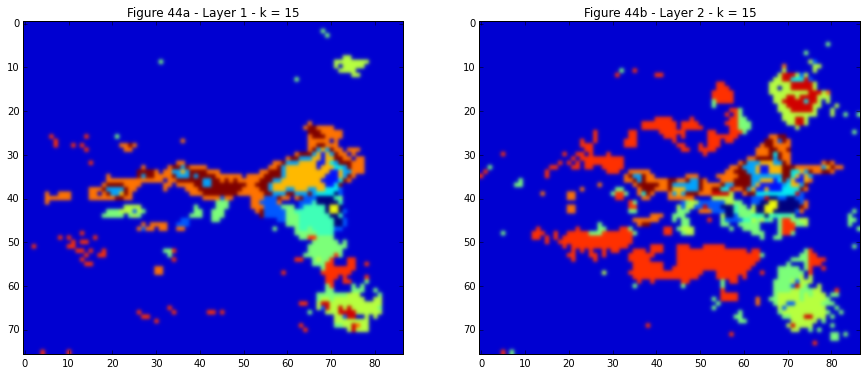

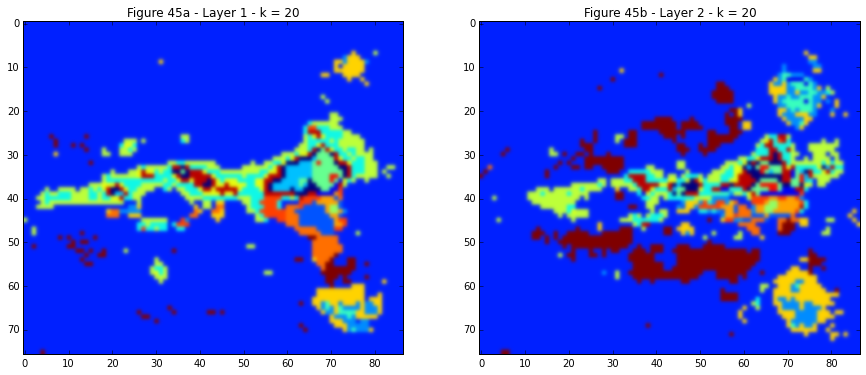

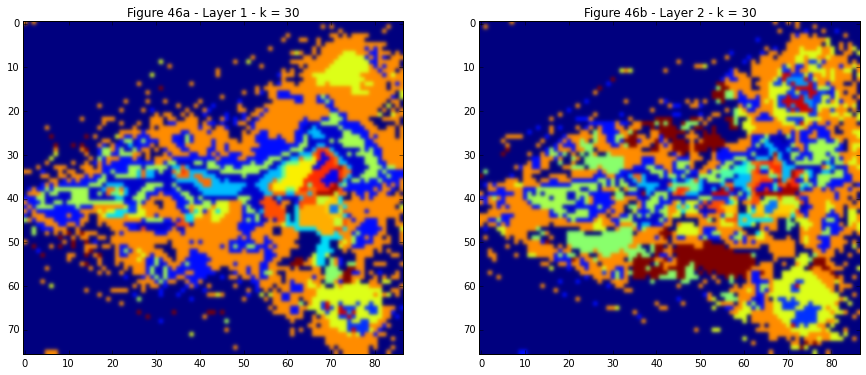

In [12]:
fig = 42
for i,k in enumerate(ks[:5]):
    gmm = GMM(k)
    gmm.fit(filtered)
    labels = data.map(lambda x: gmm.predict(x))
    imgLabels = labels.toarray().reshape(2, 76, 87)

    # newClrs = optimize_color(bestModel.centers)
    # labels = test_data.map(lambda x: bestModel.predict(x))
    # imgLabels = labels.toarray().reshape(2, 76, 87)
    # brainmap = transform(newClrs, imgLabels[0, :, :])
    # sim = train_data.map(lambda x: similarity(bestModel.centers, x))
    # imgSim = sim.toarray()

    layer = 0
    # brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[layer,:,:])
    plt.figure(figsize=(15,10))
    plt.subplot(121)
    plt.imshow(imgLabels[layer, :, :], interpolation='gaussian', aspect='equal')
    plt.title("Figure %da - Layer %d - k = %d" % (fig+i, layer+1, k))
    plt.subplot(122)
    layer = 1
    # brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[layer,:,:])
    plt.imshow(imgLabels[layer, :, :], interpolation='gaussian', aspect='equal')
    plt.title("Figure %db - Layer %d - k = %d" % (fig+i, layer+1, k))
    plt.show()

<div class="alert alert-success">
First used the filtered data to train the model, then we clustered all the data using different values of $k$. These results are very similar to the ones obtained with K-Means, but the best results are obtained with $k = 10$, since we can clearly distinguish the clusters.
</div>

<div class="alert alert-success">
<h1>Derivatives</h1>
<br>
The idea here is to use derivatives: instead of using the images as they are, we calculate the derivatives and we use them as training set. The idea is that similar voxels do not necessary behave this the same intensity, but with the same trends. That's why we think this might be interesting to try.
</div>

In [11]:
import scipy.signal as signal

data = td.images.fromexample('fish', engine=sc).toseries().normalize()
data.repartition(12)
data.cache()

Series
mode: spark
dtype: float64
shape: (2, 76, 87, 20)

In [159]:
data.tordd().repartition(6).map(lambda x: np.array(x[1])).take(1)

[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.])]

<div class="alert alert-success">
We treat the computation of the derivatives as if our data was a digital signal, thus using FIR filters. In particular, since we have very few time instants, we adopted a simple [-1, 1] derivative filter.
</div>

In [18]:
ks = [5, 10, 15, 20, 30, 50, 100, 200]
derivative_data = filtered.tordd().repartition(6)\
                                  .map(lambda x : x[1])\
                                  .map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
                                  .cache()
            
models = buildModels(derivative_data)

k = 5, training time = 6.79
k = 10, training time = 1.47
k = 15, training time = 2.11
k = 20, training time = 1.43
k = 30, training time = 1.68
k = 50, training time = 1.63
k = 100, training time = 1.25
k = 200, training time = 1.61


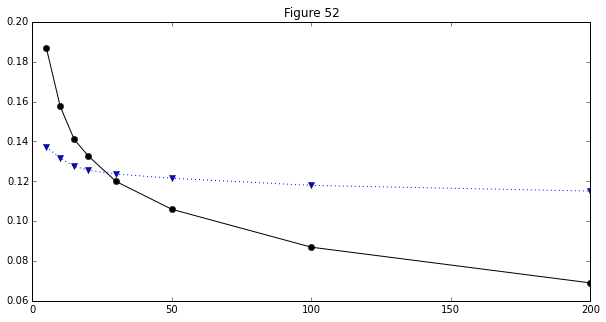

In [178]:
testAndPlotTheResult(train_data, models, 52)

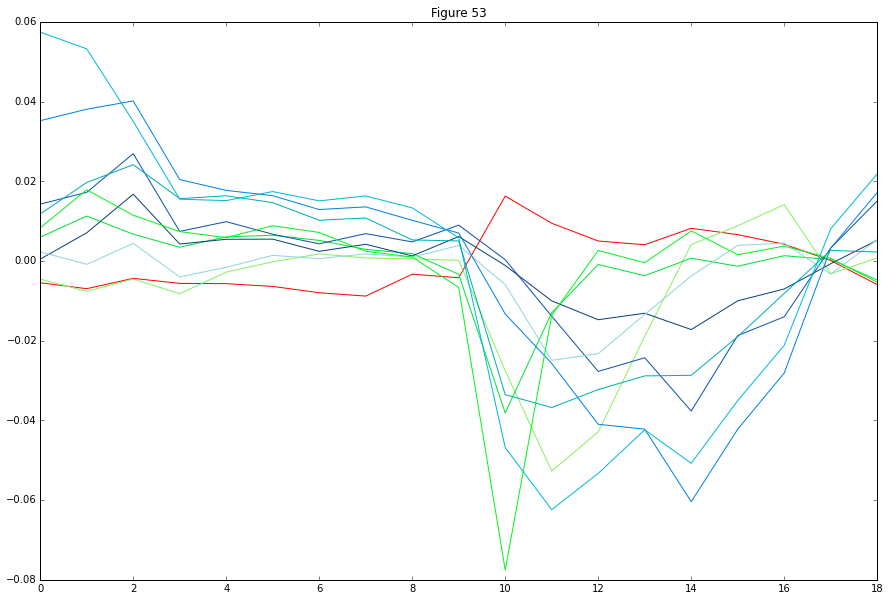

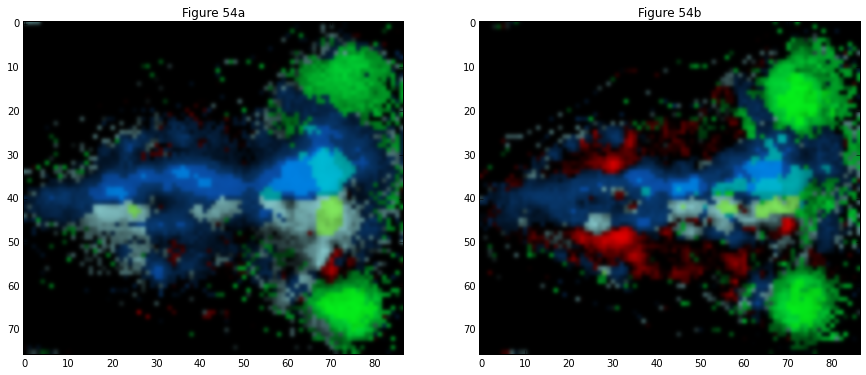

In [181]:
k_index = 1
# ks = [5, 10, 15, 20, 30, 50, 100, 200]
bestModel = models[k_index]

sim = data.map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
          .map(lambda x: similarity(bestModel.centers, x))
imgSim = sim.toarray()

# generate the better color scheme

labels = data.map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
             .map(lambda x: bestModel.predict(x))
imgLabels = labels.toarray().reshape(2, 76, 87)


newClrs = optimize_color(bestModel.centers)
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(newClrs.colors)
plt.title("Figure 53")
plt.plot(np.array(bestModel.centers).T)

plt.show()


plt.figure(figsize=(15,10))
plt.subplot(121)
brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[0])
plt.imshow(brainmap, interpolation='gaussian', aspect='equal', )
plt.title("Figure 54a")

plt.subplot(122)
brainmap = transform(newClrs, imgLabels[1,:,:], mask=imgSim[1])
plt.imshow(brainmap, interpolation='gaussian', aspect='equal', )
plt.title("Figure 54b")

plt.show()

<div class="alert alert-success">
This seems interesting and the assignment seems to better identify the various region of the brain.
<br>
Let's now split the data in training and test data and let's do the same analysis already done before. Let's start with taking samples with even time index.
</div>

k = 5, training time = 1.52
k = 10, training time = 1.62
k = 15, training time = 1.64
k = 20, training time = 1.84
k = 30, training time = 1.22
k = 50, training time = 1.44
k = 100, training time = 2.00
k = 200, training time = 1.27


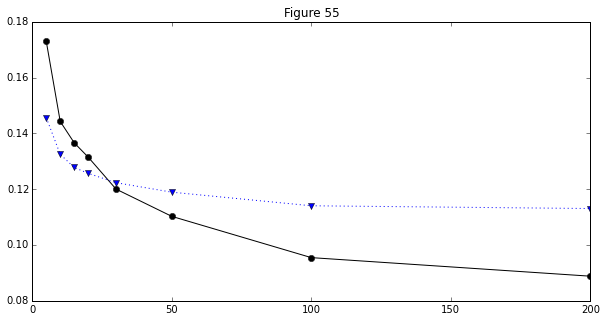

In [191]:
train_i = [i for i in range(18) if i%2==0]
test_i = [i for i in range(18) if i%2!=0]

train_data = data.select(lambda x : x in train_i)\
                 .filter(lambda x: x.std() > threshold)\
                 .tordd().repartition(6)\
                 .map(lambda x : x[1])\
                 .map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
                 .cache()
                
test_data  = data.select(lambda x : x in test_i)\
                 .filter(lambda x: x.std() > threshold)\
                 .tordd().repartition(6)\
                 .map(lambda x : x[1])\
                 .map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
                 .cache()

#test_data = data.map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
#                .select(lambda x: x in test_i)

models = buildModels(train_data)
        
testAndPlotTheResult(test_data, models, 55)

<div class="alert alert-success">
Note that when computing the derivative, our data is reduced by one element, but since we must have an even number of elements for splitting we leave the last one out, getting a voxel derivative with 18 elements.
The results obtained here are not so different from the previous experiments with this regular sampling but on the time series and not on the derivatives.
<br><br>
Let's now take 10 random samples between t = 0 and t = 17.
</div>

k = 5, training time = 2.87
k = 10, training time = 1.41
k = 15, training time = 1.57
k = 20, training time = 2.32
k = 30, training time = 1.76
k = 50, training time = 2.18
k = 100, training time = 1.40
k = 200, training time = 1.38


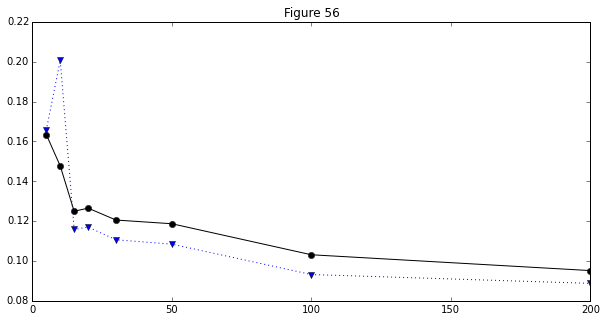

In [193]:
indices = np.arange(18)
np.random.shuffle(indices)
train_i = indices[:9]
test_i = indices[9:]

train_data = data.select(lambda x : x in train_i)\
                 .filter(lambda x: x.std() > threshold)\
                 .tordd().repartition(6)\
                 .map(lambda x : x[1])\
                 .map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
                 .cache()
                
test_data  = data.select(lambda x : x in test_i)\
                 .filter(lambda x: x.std() > threshold)\
                 .tordd().repartition(6)\
                 .map(lambda x : x[1])\
                 .map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
                 .cache()

#test_data = data.map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
#                .select(lambda x: x in test_i)

models = buildModels(train_data)
        
testAndPlotTheResult(test_data, models, 56)

<div class="alert alert-success">
And now let's take the first 10 samples for training.
</div>

k = 5, training time = 2.35
k = 10, training time = 1.30
k = 15, training time = 0.73
k = 20, training time = 1.02
k = 30, training time = 0.97
k = 50, training time = 0.93
k = 100, training time = 1.01
k = 200, training time = 0.85


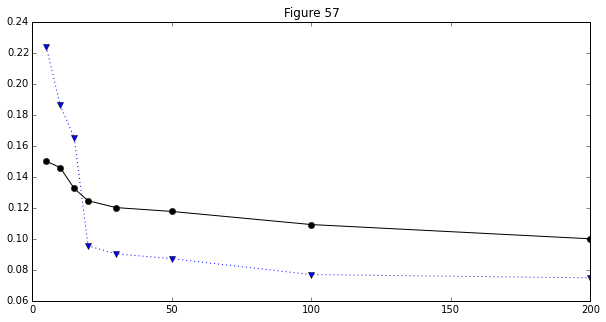

In [221]:
indices = np.arange(18)
train_i = indices[:9]
test_i = indices[9:]

train_data = data.select(lambda x : x in train_i)\
                 .filter(lambda x: x.std() > threshold)\
                 .tordd().repartition(6)\
                 .map(lambda x : x[1])\
                 .map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
                 .cache()
                
test_data  = data.select(lambda x : x in test_i)\
                 .filter(lambda x: x.std() > threshold)\
                 .tordd().repartition(6)\
                 .map(lambda x : x[1])\
                 .map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
                 .cache()

#test_data = data.map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
#                .select(lambda x: x in test_i)

models = buildModels(train_data)
        
testAndPlotTheResult(test_data, models, 57)

<div class="alert alert-success">
This result is interesting and the best k seems to be 20. Here we see that clustering is much easier and errors are definatively lower than before (see Figure 40-41).
<br>
If we compare these results with the standard case where the original time serie was used, we can appreciate how our hypothesis on derivatives is confirmed: in the context of grouping together similar voxels (i.e. clustering neurons that respond in similar way to a pre-defined stimulus), variations are more important than the plain intensity.
<br>
Now, that we have this information, we can run the training with the whole dataset, selecting k equal to 20.
</div>

k = 5, training time = 1.09
k = 10, training time = 1.97
k = 15, training time = 2.41
k = 20, training time = 2.07
k = 30, training time = 1.08
k = 50, training time = 1.39
k = 100, training time = 1.40
k = 200, training time = 1.05


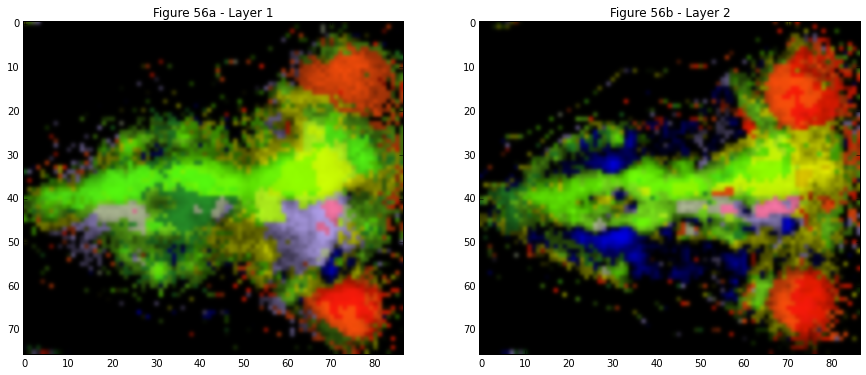

In [238]:
models = buildModels(derivative_data)
best_k_index = 3
best_k = ks[best_k_index]
bestModel = models[best_k_index]

newClrs = optimize_color(bestModel.centers)
labels = data.map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
             .map(lambda x: bestModel.predict(x))

imgLabels = labels.toarray().reshape(2, 76, 87)
brainmap = transform(newClrs, imgLabels[0, :, :])

sim = data.map(lambda x: signal.convolve(x, np.array([-1, 1]), mode='valid'))\
          .map(lambda x: similarity(bestModel.centers, x))
                
imgSim = sim.toarray()

layer = 0
brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[layer,:,:])
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(brainmap, interpolation='gaussian', aspect='equal')
plt.title("Figure 56a - Layer %d" % (layer+1))
plt.subplot(122)

layer = 1
brainmap = transform(newClrs, imgLabels[1,:,:], mask=imgSim[layer,:,:])
plt.imshow(brainmap, interpolation='gaussian', aspect='equal')
plt.title("Figure 56b - Layer %d" % (layer+1))
plt.show()

<div class="alert alert-success">
Let's compare this result with the image from the Nature article.
</div>

![alt text](http://www.nature.com/nmeth/journal/v11/n9/images_article/nmeth.3041-F5.jpg)

<div class="alert alert-success">
Maps of sensorimotor responses in larval zebrafish. (a) Maps of response dynamics obtained by reducing each voxel to a pair of numbers using PCA. (b) Stimulus sequence and calcium responses of individual neurons; examples highlight different response types. (c) Map derived from an experiment in which the fish swam sporadically in response to a
constantly slowly moving stimulus. (d) Swimming strength and calcium responses of individual neurons during self-driven swimming.
<br><br>
At least qualitatively, it seems to be be a good result even though this images was obtained using the full dataset.
</div>



<div class="alert alert-success">
<h1> DBSCAN </h1><br>
Now, we want to try with a different algorithm for clustering: DBSCAN. The goal of this algorithm is to identify dense regions, which can be measured by the number of objects close to a given point. Two important parameters are required for DBSCAN: epsilon and minimum points. The parameter eps defines the radius of neighborhood around a point x, while the other parameter is the minimum number of neighbors within eps radius.
</div>

In [4]:
from sklearn.cluster import DBSCAN, SpectralClustering

/opt/conda/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


Estimated number of clusters: 26


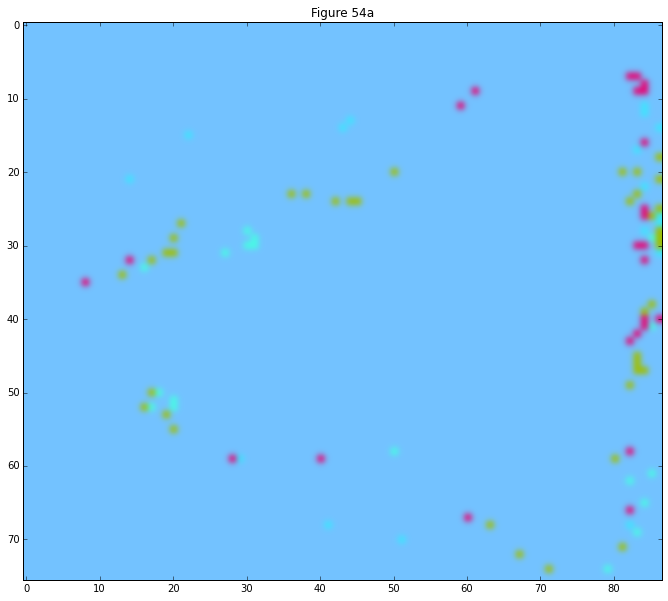

In [21]:
train_data = data.tordd().map(lambda x:x[1]).collect()
                
model = DBSCAN(eps=1e-3, min_samples=5).fit(train_data)

labels = model.labels_.astype(np.int)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

imgLabels = labels.reshape(2, 76, 87)

brainmap = transform(newClrs, imgLabels[0,:,:])
plt.figure(figsize=(15,10))
plt.imshow(brainmap, interpolation='gaussian', aspect='equal', )
plt.title("Figure 54a")
plt.show()

<div class="alert alert-success">
Even though we didn't manage to find the right set of parameters, for sake of completeness we leave this result. 
</div>

<div class="alert alert-success">
<h2> Spectral Clustering </h2><br>

Spectral clustering refers to a class of techniques which rely on the eigenstructure
of a similarity matrix to partition points into disjoint clusters, with points in the same
cluster having high similarity and points in different clusters having low similarity.
</div>

In [ ]:
train_data = data.tordd().map(lambda x:x[1]).collect()
                
model = SpectralClustering(n_clusters=10).fit(train_data)

labels = model.labels_.astype(np.int)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

imgLabels = labels.reshape(2, 76, 87)
brainmap = transform(newClrs, imgLabels[0,:,:])
plt.figure(figsize=(15,10))
plt.imshow(brainmap, interpolation='gaussian', aspect='equal', )
plt.title("Figure 54a")
plt.show()

![alt text](http://i.imgur.com/1zuCqEm.png)


<div class="alert alert-success">
Visually, it's a good assignment to the voxels and it's comparable with the standard KMeans. This result shows us that this time series can be clustered also with more complicated method.
</div>

# 4. Summary
We studied Thunder and its important methods to work with images, such as `Image`, `Series` and how to apply them to a use case. In the use case, we used the K-Means algorithm to cluster the neurons without prior knowledge of what a good choice of K could be. Subsequently, we introduced some techniques for improving the initially obtained results, such as removing noise and considering similarity.

# References
Some of the examples in this notebook are inspired from the [documentation of Thunder](http://docs.thunder-project.org/).

[1] Vladimirov et al, "Light-sheet functional imaging in fictively behaving zebrafish", Nature, 2014

[2] Freeman et al, "Mapping brain activity at scale with cluster computing", Nature, 2014